# Tracking the Growth of COVID-19 Cases

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in various countries.

**The notebook pulls data from the Johns Hopkins [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global Coronavirus COVID-19 cases**, and then does the following things:

- List cumulative number of confirmed cases (in countries with at least 100 confirmed cases)
- Attempt to fit the time series of cumulative confirmed cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of cumulative confirmed cases to double)

We then repeat these steps for US states.

The notebook is updated approximately daily.

## Caveats:

- The confirmed cases reported by each country are different from the number of infected people in each country.


- **The doubling time calculated here measures the growth of cumulative confirmed cases, which is different from the growth of infected people.** For example, if a country suddenly ramps up testing, then the number of confirmed cases will rapidly rise, but the actual cases may not be rising as the same rate.


- The doubling times inferred from the curve fits are not necessarily the current or most recent doubling times: 
    - For countries where the growth is still exponential, the inferred doubling time gives us a picture of the overall rate of growth. 
    - For countries where the growth is no longer exponential, and the number of cases is stabilizing (such as China and South Korea), we use a logistic function to fit the data instead. Here, the inferred doubling time represents the growth encountered during the middle of the growth of the epidemic. 
    - Finally, we compare these values to the recent doubling time, calculated from the most recent week of data.


- The growth rate (or recent doubling time) changes with time, and will eventually fall to zero. So be cautious about extrapolating trends into the future based on current growth rates. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

## Global COVID-19 Analysis

In [3]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases


Total number of cases (in countries with at least 100 cases) as of 3/20/20


,3/20/20
Country/Region,
China,81250
Italy,47021
Spain,20410
Germany,19848
Iran,19644
US,19100
France,12726
"Korea, South",8652
Switzerland,5294


## Curve Fitting Global COVID-19 Cases

In [4]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Original Data")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
    
    plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



China

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 81250
	Confirmed cases on 3/13/20 	 80945
	Ratio: 1.0
	Weekly increase: 0.4 %
	Daily increase: 0.1 % per day
	Doubling Time (represents recent growth): 1290.1 days

** Based on Logistic Fit**

	R^2: 0.995366445322
	Doubling Time (during middle of growth):  6.46 (± 0.54 ) days


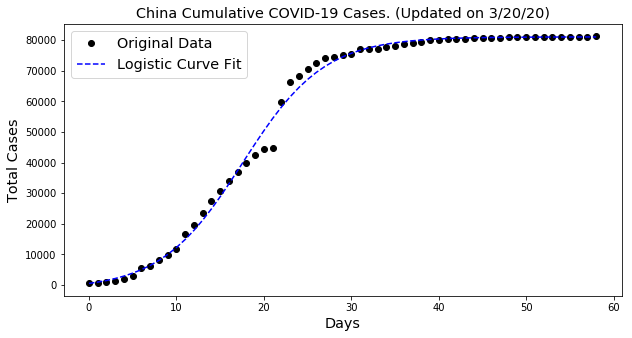



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 47021
	Confirmed cases on 3/13/20 	 17660
	Ratio: 2.66
	Weekly increase: 166.3 %
	Daily increase: 15.0 % per day
	Doubling Time (represents recent growth): 5.0 days

** Based on Logistic Fit**

	R^2: 0.998709777572
	Doubling Time (during middle of growth):  6.87 (± 0.41 ) days

** Based on Exponential Fit **

	R^2: 0.995366851931
	Doubling Time (represents overall growth):  4.5 (± 0.19 ) days


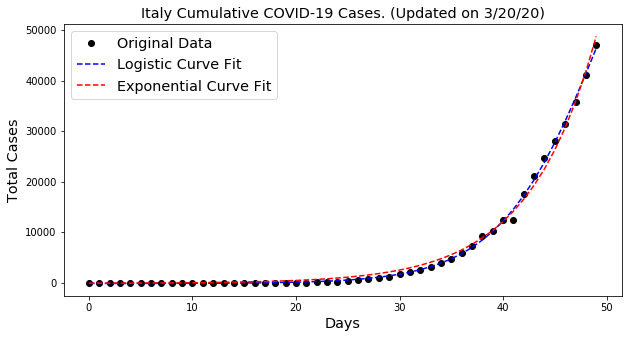



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 20410
	Confirmed cases on 3/13/20 	 5232
	Ratio: 3.9
	Weekly increase: 290.1 %
	Daily increase: 21.5 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Exponential Fit **

	R^2: 0.991090378481
	Doubling Time (represents overall growth):  3.16 (± 0.18 ) days


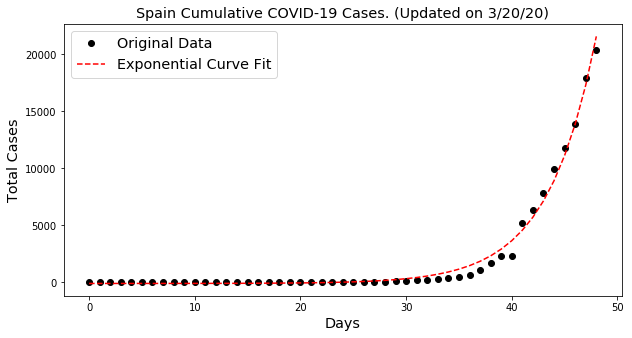



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 19848
	Confirmed cases on 3/13/20 	 3675
	Ratio: 5.4
	Weekly increase: 440.1 %
	Daily increase: 27.2 % per day
	Doubling Time (represents recent growth): 2.9 days

** Based on Exponential Fit **

	R^2: 0.999209856275
	Doubling Time (represents overall growth):  2.76 (± 0.04 ) days


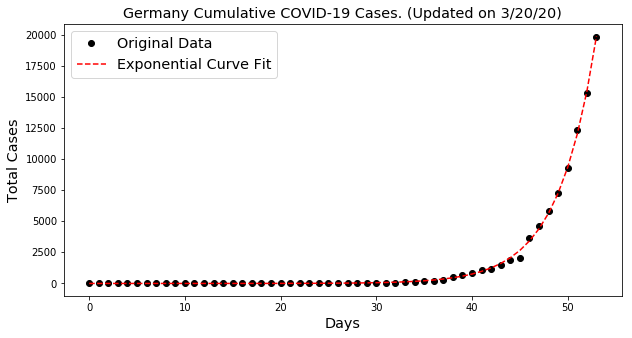



Iran

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 19644
	Confirmed cases on 3/13/20 	 11364
	Ratio: 1.73
	Weekly increase: 72.9 %
	Daily increase: 8.1 % per day
	Doubling Time (represents recent growth): 8.9 days

** Based on Logistic Fit**

	R^2: 0.997656315966
	Doubling Time (during middle of growth):  7.35 (± 0.83 ) days


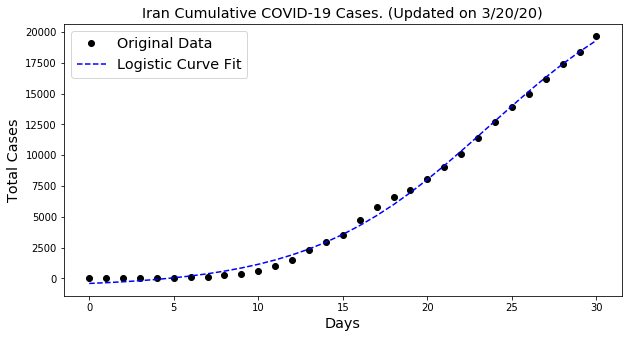



US

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 19100
	Confirmed cases on 3/13/20 	 2179
	Ratio: 8.77
	Weekly increase: 776.5 %
	Daily increase: 36.4 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Exponential Fit **

	R^2: 0.993839104134
	Doubling Time (represents overall growth):  1.97 (± 0.08 ) days


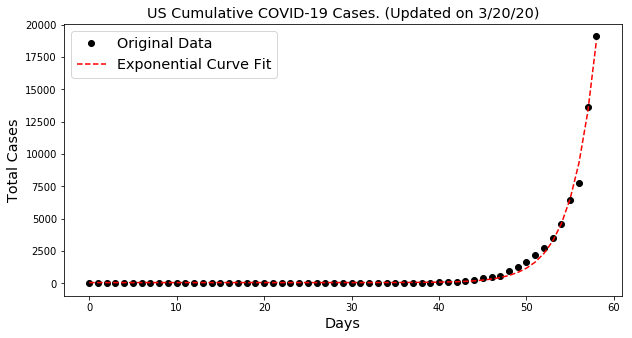



France

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 12726
	Confirmed cases on 3/13/20 	 3678
	Ratio: 3.46
	Weekly increase: 246.0 %
	Daily increase: 19.4 % per day
	Doubling Time (represents recent growth): 3.9 days

** Based on Exponential Fit **

	R^2: 0.995655723724
	Doubling Time (represents overall growth):  3.59 (± 0.13 ) days


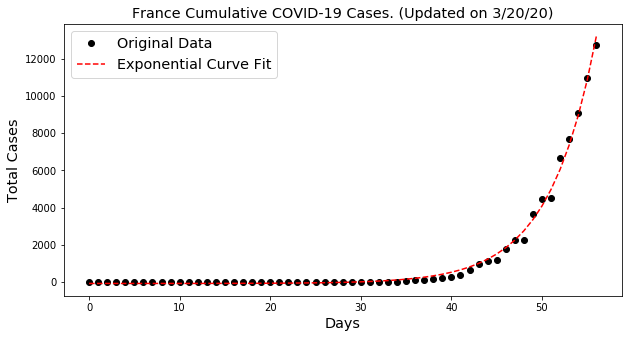



Korea, South

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 8652
	Confirmed cases on 3/13/20 	 7979
	Ratio: 1.08
	Weekly increase: 8.4 %
	Daily increase: 1.2 % per day
	Doubling Time (represents recent growth): 59.9 days

** Based on Logistic Fit**

	R^2: 0.999089894364
	Doubling Time (during middle of growth):  4.27 (± 0.17 ) days


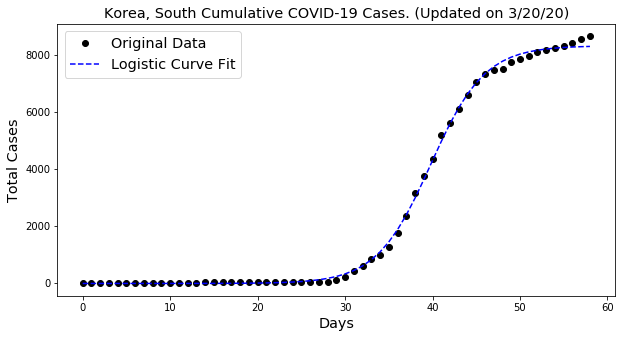



Switzerland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 5294
	Confirmed cases on 3/13/20 	 1139
	Ratio: 4.65
	Weekly increase: 364.8 %
	Daily increase: 24.5 % per day
	Doubling Time (represents recent growth): 3.2 days

** Based on Logistic Fit**

	R^2: 0.991667742765
	Doubling Time (during middle of growth):  6.45 (± 2.03 ) days

** Based on Exponential Fit **

	R^2: 0.991667742927
	Doubling Time (represents overall growth):  3.23 (± 0.29 ) days


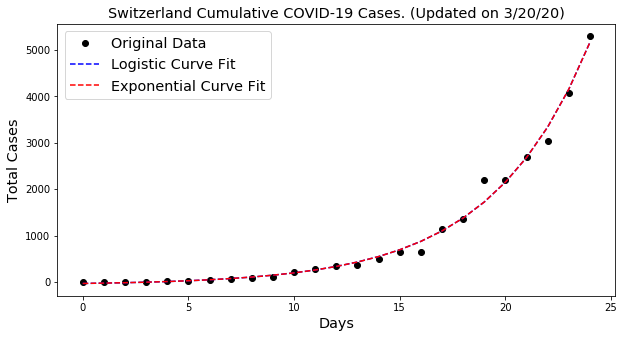



United Kingdom

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 4014
	Confirmed cases on 3/13/20 	 802
	Ratio: 5.0
	Weekly increase: 400.5 %
	Daily increase: 25.9 % per day
	Doubling Time (represents recent growth): 3.0 days

** Based on Exponential Fit **

	R^2: 0.992452033715
	Doubling Time (represents overall growth):  3.0 (± 0.15 ) days


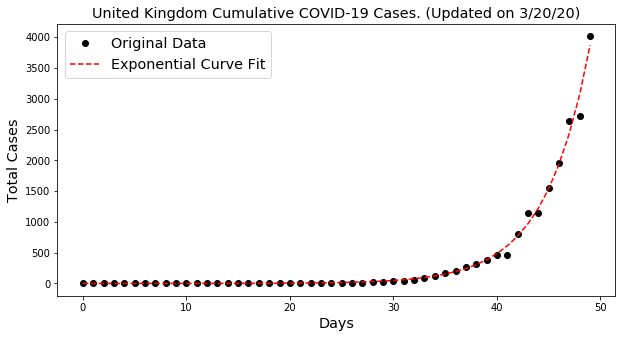



Netherlands

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 3003
	Confirmed cases on 3/13/20 	 806
	Ratio: 3.73
	Weekly increase: 272.6 %
	Daily increase: 20.7 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Logistic Fit**

	R^2: 0.998809307926
	Doubling Time (during middle of growth):  6.68 (± 0.9 ) days

** Based on Exponential Fit **

	R^2: 0.998642992823
	Doubling Time (represents overall growth):  3.74 (± 0.16 ) days


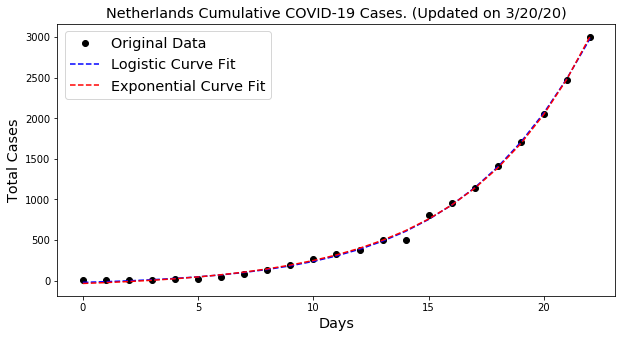



Austria

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 2388
	Confirmed cases on 3/13/20 	 504
	Ratio: 4.74
	Weekly increase: 373.8 %
	Daily increase: 24.9 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Logistic Fit**

	R^2: 0.999266927602
	Doubling Time (during middle of growth):  4.39 (± 0.3 ) days

** Based on Exponential Fit **

	R^2: 0.995995763326
	Doubling Time (represents overall growth):  3.19 (± 0.2 ) days


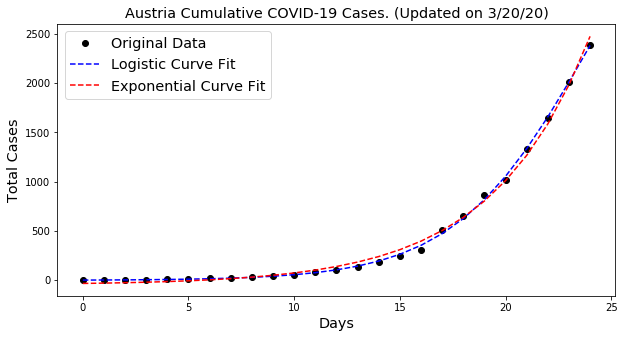



Belgium

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 2257
	Confirmed cases on 3/13/20 	 559
	Ratio: 4.04
	Weekly increase: 303.8 %
	Daily increase: 22.1 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Exponential Fit **

	R^2: 0.996383133382
	Doubling Time (represents overall growth):  3.4 (± 0.13 ) days


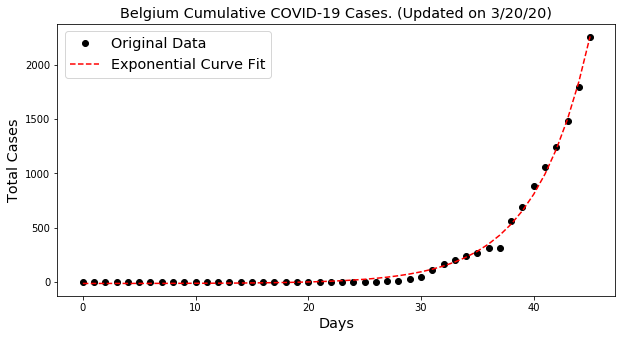



Norway

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 1914
	Confirmed cases on 3/13/20 	 996
	Ratio: 1.92
	Weekly increase: 92.2 %
	Daily increase: 9.8 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.993849153868
	Doubling Time (during middle of growth):  3.94 (± 0.67 ) days

** Based on Exponential Fit **

	R^2: 0.963289577036
	Doubling Time (represents overall growth):  5.13 (± 1.32 ) days


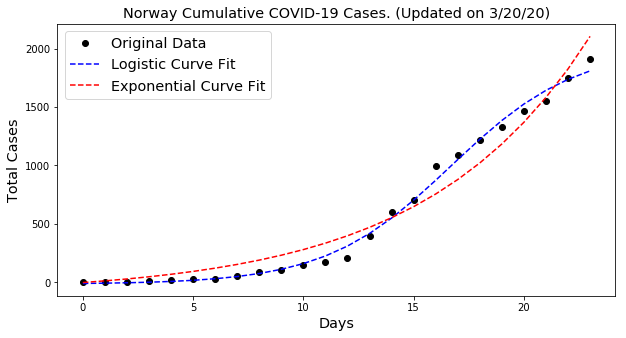



Sweden

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 1639
	Confirmed cases on 3/13/20 	 814
	Ratio: 2.01
	Weekly increase: 101.4 %
	Daily increase: 10.5 % per day
	Doubling Time (represents recent growth): 6.9 days

** Based on Logistic Fit**

	R^2: 0.995028853191
	Doubling Time (during middle of growth):  4.26 (± 0.43 ) days

** Based on Exponential Fit **

	R^2: 0.972370537033
	Doubling Time (represents overall growth):  4.95 (± 0.52 ) days


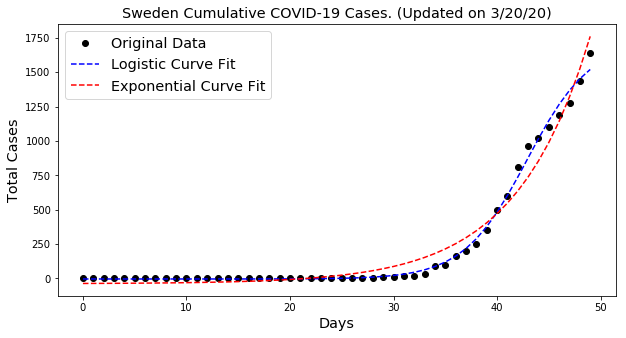



Denmark

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 1337
	Confirmed cases on 3/13/20 	 804
	Ratio: 1.66
	Weekly increase: 66.3 %
	Daily increase: 7.5 % per day
	Doubling Time (represents recent growth): 9.5 days

** Based on Logistic Fit**

	R^2: 0.983608691917
	Doubling Time (during middle of growth):  2.96 (± 0.79 ) days


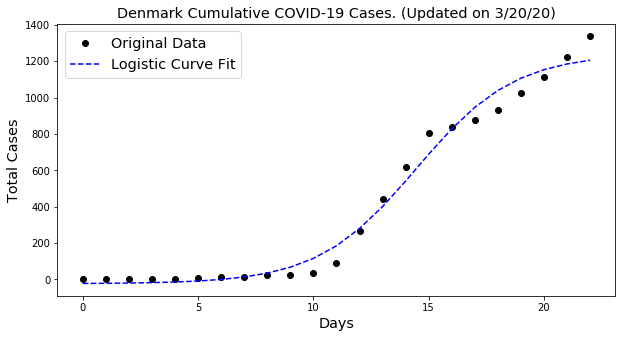



Malaysia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 1030
	Confirmed cases on 3/13/20 	 197
	Ratio: 5.23
	Weekly increase: 422.8 %
	Daily increase: 26.7 % per day
	Doubling Time (represents recent growth): 2.9 days

** Based on Exponential Fit **

	R^2: 0.985719598553
	Doubling Time (represents overall growth):  3.32 (± 0.22 ) days


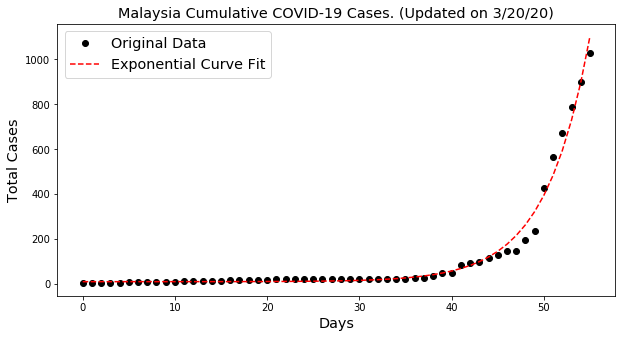



Portugal

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 1020
	Confirmed cases on 3/13/20 	 112
	Ratio: 9.11
	Weekly increase: 810.7 %
	Daily increase: 37.1 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.989113604038
	Doubling Time (during middle of growth):  4.58 (± 1.85 ) days

** Based on Exponential Fit **

	R^2: 0.989113604362
	Doubling Time (represents overall growth):  2.29 (± 0.27 ) days


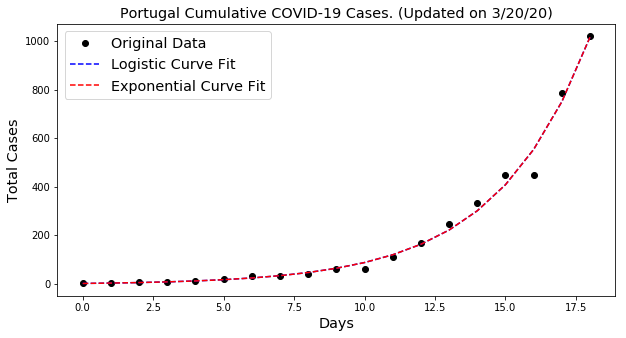



Japan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 963
	Confirmed cases on 3/13/20 	 701
	Ratio: 1.37
	Weekly increase: 37.4 %
	Daily increase: 4.6 % per day
	Doubling Time (represents recent growth): 15.3 days

** Based on Logistic Fit**

	R^2: 0.997699509182
	Doubling Time (during middle of growth):  10.99 (± 0.78 ) days

** Based on Exponential Fit **

	R^2: 0.98865991485
	Doubling Time (represents overall growth):  10.87 (± 0.83 ) days


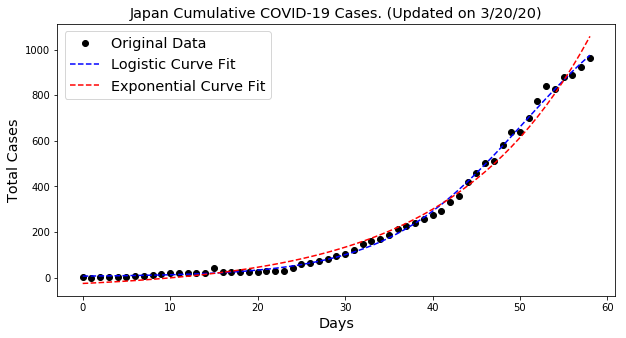



Canada

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 943
	Confirmed cases on 3/13/20 	 193
	Ratio: 4.89
	Weekly increase: 388.6 %
	Daily increase: 25.4 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Exponential Fit **

	R^2: 0.994622640421
	Doubling Time (represents overall growth):  2.86 (± 0.12 ) days


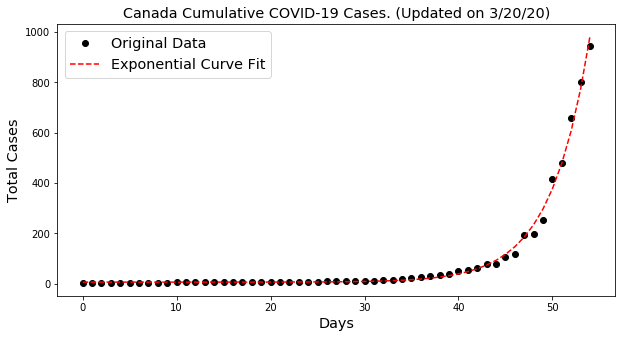



Czechia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 833
	Confirmed cases on 3/13/20 	 141
	Ratio: 5.91
	Weekly increase: 490.8 %
	Daily increase: 28.9 % per day
	Doubling Time (represents recent growth): 2.7 days

** Based on Logistic Fit**

	R^2: 0.995645560035
	Doubling Time (during middle of growth):  5.32 (± 1.45 ) days

** Based on Exponential Fit **

	R^2: 0.995625068634
	Doubling Time (represents overall growth):  2.76 (± 0.21 ) days


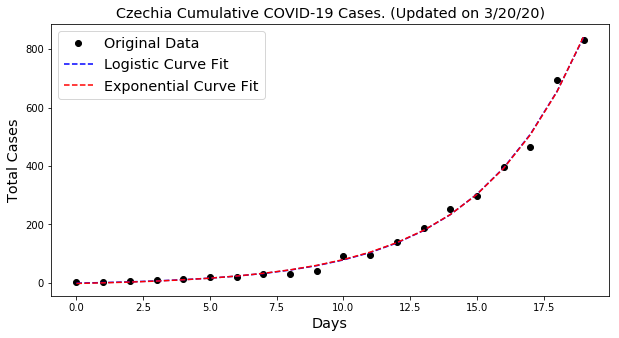



Brazil

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 793
	Confirmed cases on 3/13/20 	 151
	Ratio: 5.25
	Weekly increase: 425.2 %
	Daily increase: 26.7 % per day
	Doubling Time (represents recent growth): 2.9 days

** Based on Exponential Fit **

	R^2: 0.989774477652
	Doubling Time (represents overall growth):  2.21 (± 0.21 ) days


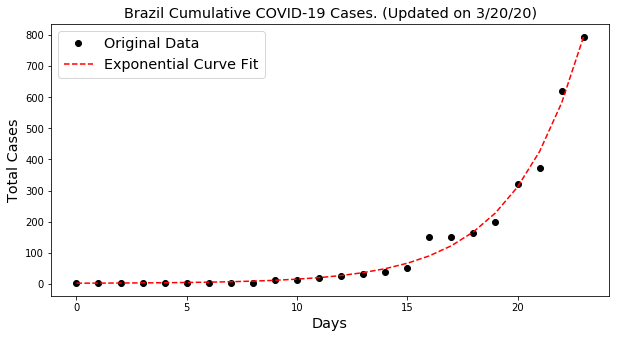



Australia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 791
	Confirmed cases on 3/13/20 	 200
	Ratio: 3.96
	Weekly increase: 295.5 %
	Daily increase: 21.7 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Exponential Fit **

	R^2: 0.997502706511
	Doubling Time (represents overall growth):  3.35 (± 0.09 ) days


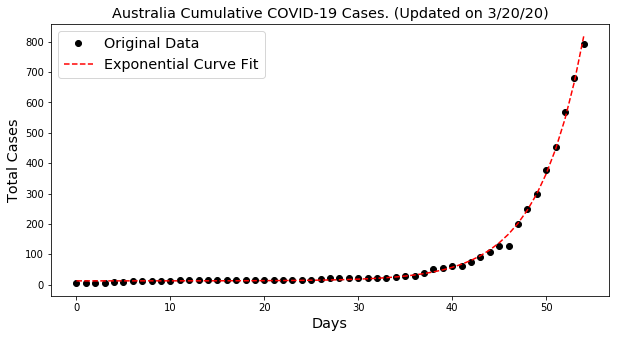



Cruise Ship

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 712
	Confirmed cases on 3/13/20 	 696
	Ratio: 1.02
	Weekly increase: 2.3 %
	Daily increase: 0.3 % per day
	Doubling Time (represents recent growth): 213.5 days

** Based on Logistic Fit**

	R^2: 0.995646993494
	Doubling Time (during middle of growth):  2.7 (± 0.27 ) days


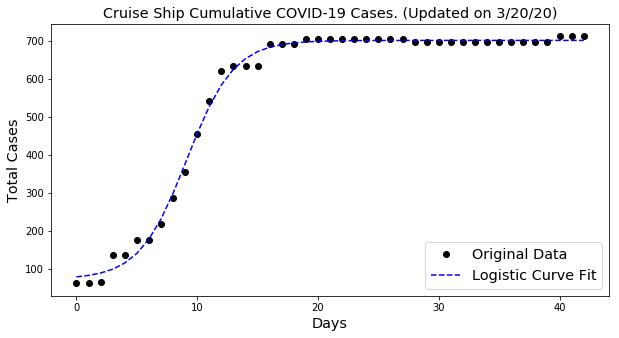



Israel

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 705
	Confirmed cases on 3/13/20 	 161
	Ratio: 4.38
	Weekly increase: 337.9 %
	Daily increase: 23.5 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Logistic Fit**

	R^2: 0.986239255474
	Doubling Time (during middle of growth):  6.1 (± 1.86 ) days

** Based on Exponential Fit **

	R^2: 0.986239256786
	Doubling Time (represents overall growth):  3.05 (± 0.31 ) days


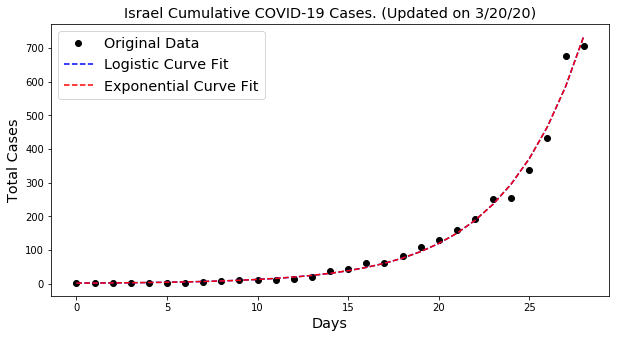



Ireland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 683
	Confirmed cases on 3/13/20 	 90
	Ratio: 7.59
	Weekly increase: 658.9 %
	Daily increase: 33.6 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Exponential Fit **

	R^2: 0.98466076426
	Doubling Time (represents overall growth):  1.97 (± 0.25 ) days


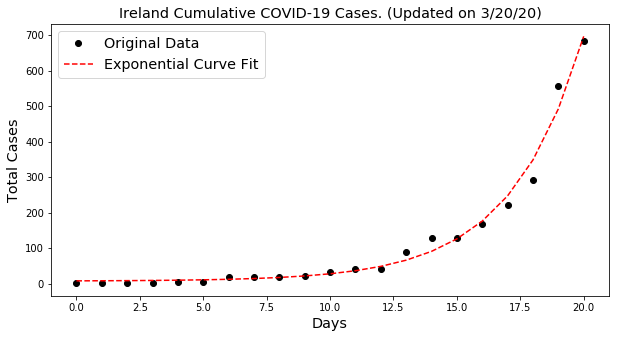



Pakistan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 501
	Confirmed cases on 3/13/20 	 28
	Ratio: 17.89
	Weekly increase: 1689.3 %
	Daily increase: 51.0 % per day
	Doubling Time (represents recent growth): 1.7 days

** Based on Exponential Fit **

	R^2: 0.973566007934
	Doubling Time (represents overall growth):  2.08 (± 0.32 ) days


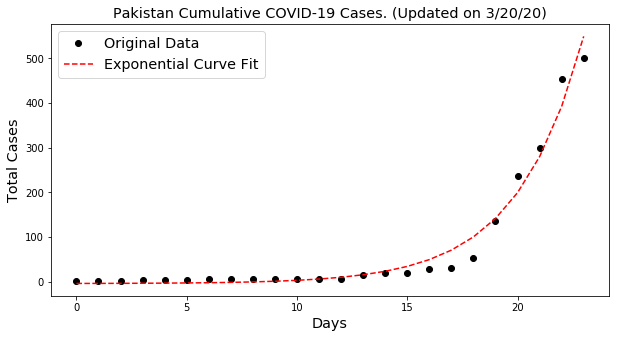



Greece

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 495
	Confirmed cases on 3/13/20 	 190
	Ratio: 2.61
	Weekly increase: 160.5 %
	Daily increase: 14.7 % per day
	Doubling Time (represents recent growth): 5.1 days

** Based on Logistic Fit**

	R^2: 0.987378776533
	Doubling Time (during middle of growth):  3.68 (± 0.9 ) days

** Based on Exponential Fit **

	R^2: 0.968890386909
	Doubling Time (represents overall growth):  5.49 (± 1.31 ) days


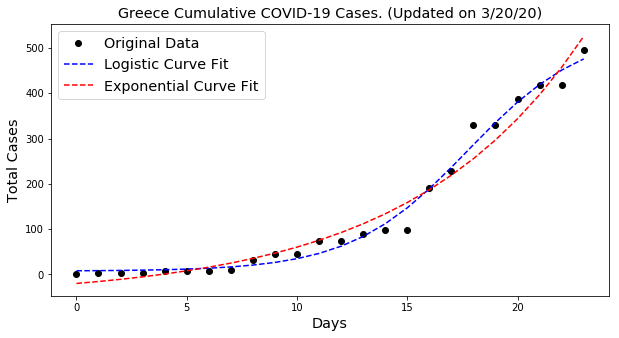



Luxembourg

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 484
	Confirmed cases on 3/13/20 	 34
	Ratio: 14.24
	Weekly increase: 1323.5 %
	Daily increase: 46.1 % per day
	Doubling Time (represents recent growth): 1.8 days

** Based on Exponential Fit **

	R^2: 0.997793573065
	Doubling Time (represents overall growth):  1.65 (± 0.08 ) days


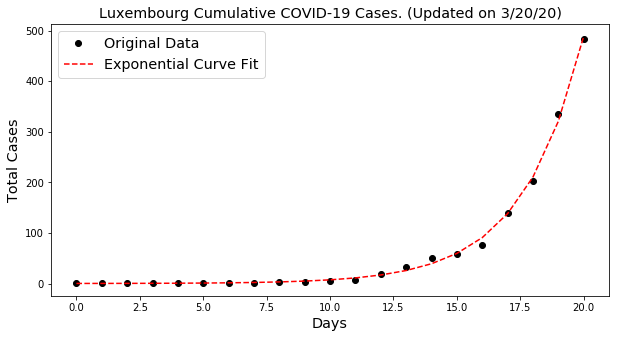



Qatar

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 470
	Confirmed cases on 3/13/20 	 320
	Ratio: 1.47
	Weekly increase: 46.9 %
	Daily increase: 5.6 % per day
	Doubling Time (represents recent growth): 12.6 days

** Based on Logistic Fit**

	R^2: 0.976198939215
	Doubling Time (during middle of growth):  1.85 (± 0.65 ) days


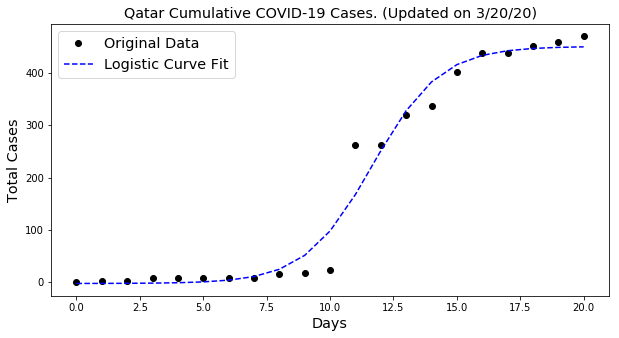



Finland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 450
	Confirmed cases on 3/13/20 	 155
	Ratio: 2.9
	Weekly increase: 190.3 %
	Daily increase: 16.4 % per day
	Doubling Time (represents recent growth): 4.6 days

** Based on Exponential Fit **

	R^2: 0.967683193761
	Doubling Time (represents overall growth):  3.83 (± 0.41 ) days


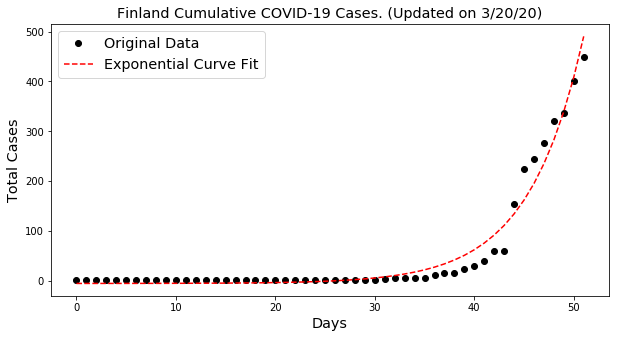



Chile

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 434
	Confirmed cases on 3/13/20 	 43
	Ratio: 10.09
	Weekly increase: 909.3 %
	Daily increase: 39.1 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.968452368726
	Doubling Time (during middle of growth):  4.8 (± 4.71 ) days

** Based on Exponential Fit **

	R^2: 0.968452370693
	Doubling Time (represents overall growth):  2.4 (± 0.52 ) days


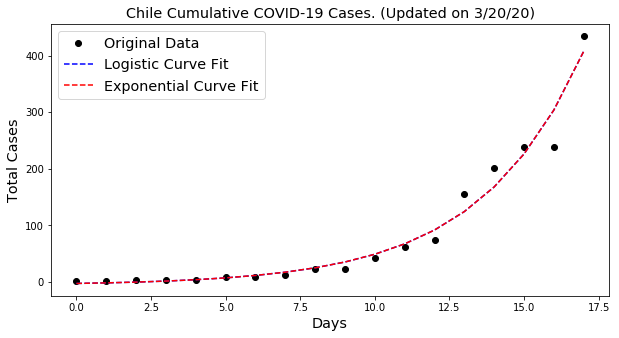



Poland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 425
	Confirmed cases on 3/13/20 	 68
	Ratio: 6.25
	Weekly increase: 525.0 %
	Daily increase: 29.9 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Logistic Fit**

	R^2: 0.994888947518
	Doubling Time (during middle of growth):  4.47 (± 1.32 ) days

** Based on Exponential Fit **

	R^2: 0.993440775813
	Doubling Time (represents overall growth):  3.11 (± 0.36 ) days


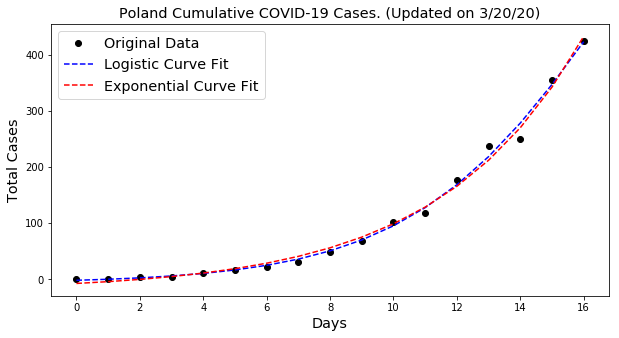



Iceland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 409
	Confirmed cases on 3/13/20 	 134
	Ratio: 3.05
	Weekly increase: 205.2 %
	Daily increase: 17.3 % per day
	Doubling Time (represents recent growth): 4.3 days

** Based on Logistic Fit**

	R^2: 0.98965043337
	Doubling Time (during middle of growth):  8.46 (± 1.0 ) days

** Based on Exponential Fit **

	R^2: 0.989650433684
	Doubling Time (represents overall growth):  4.23 (± 0.54 ) days


/Users/aatish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


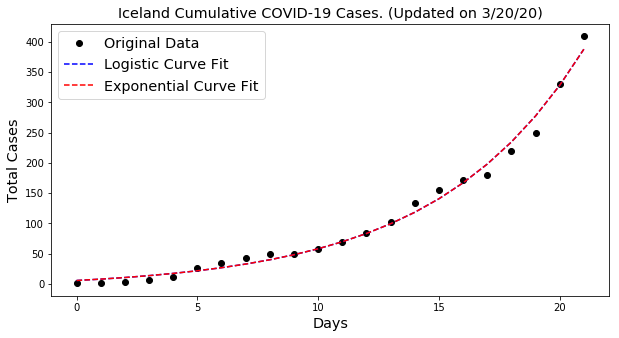



Singapore

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 385
	Confirmed cases on 3/13/20 	 200
	Ratio: 1.92
	Weekly increase: 92.5 %
	Daily increase: 9.8 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.961937294266
	Doubling Time (during middle of growth):  20.63 (± 3.14 ) days

** Based on Exponential Fit **

	R^2: 0.961937295098
	Doubling Time (represents overall growth):  10.31 (± 1.44 ) days


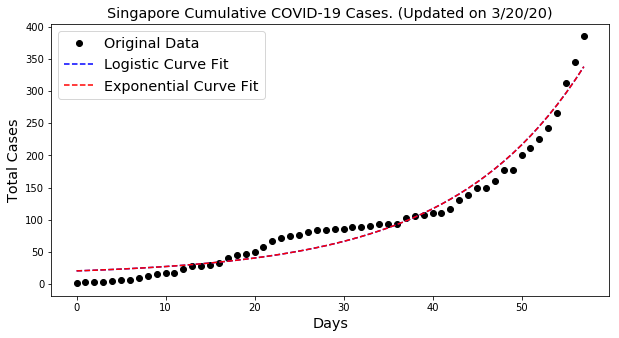



Indonesia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 369
	Confirmed cases on 3/13/20 	 69
	Ratio: 5.35
	Weekly increase: 434.8 %
	Daily increase: 27.1 % per day
	Doubling Time (represents recent growth): 2.9 days

** Based on Logistic Fit**

	R^2: 0.995639884023
	Doubling Time (during middle of growth):  5.16 (± 1.43 ) days

** Based on Exponential Fit **

	R^2: 0.995406357295
	Doubling Time (represents overall growth):  2.92 (± 0.24 ) days


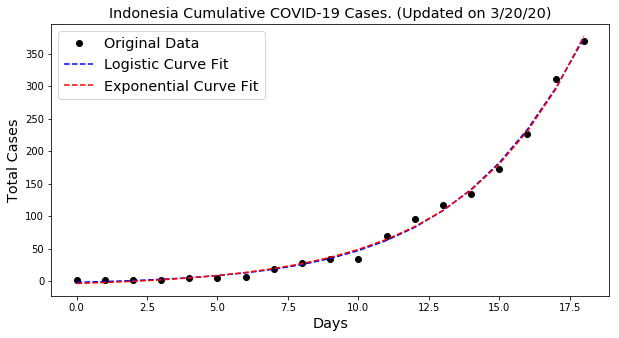



Ecuador

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 367
	Confirmed cases on 3/13/20 	 17
	Ratio: 21.59
	Weekly increase: 2058.8 %
	Daily increase: 55.1 % per day
	Doubling Time (represents recent growth): 1.6 days

** Based on Exponential Fit **

	R^2: 0.998247741518
	Doubling Time (represents overall growth):  1.07 (± 0.05 ) days


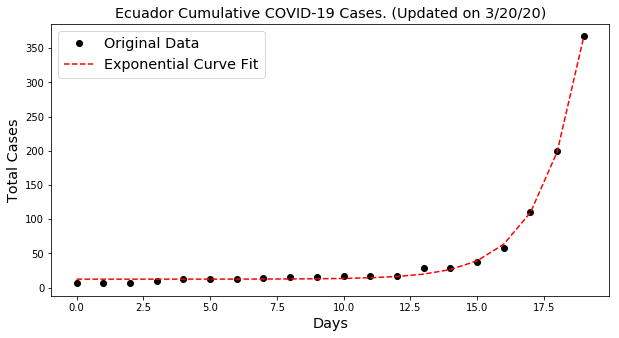



Turkey

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 359
	Confirmed cases on 3/13/20 	 5
	Ratio: 71.8
	Weekly increase: 7080.0 %
	Daily increase: 84.1 % per day
	Doubling Time (represents recent growth): 1.1 days

** Based on Exponential Fit **

	R^2: 0.998973221179
	Doubling Time (represents overall growth):  1.07 (± 0.06 ) days


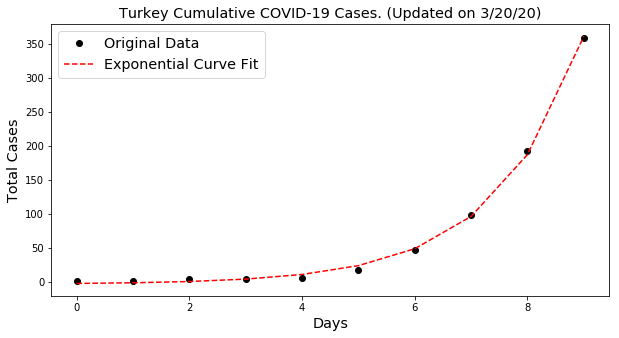



Saudi Arabia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 344
	Confirmed cases on 3/13/20 	 86
	Ratio: 4.0
	Weekly increase: 300.0 %
	Daily increase: 21.9 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Logistic Fit**

	R^2: 0.981515119088
	Doubling Time (during middle of growth):  5.96 (± 2.33 ) days

** Based on Exponential Fit **

	R^2: 0.981515120128
	Doubling Time (represents overall growth):  2.98 (± 0.51 ) days


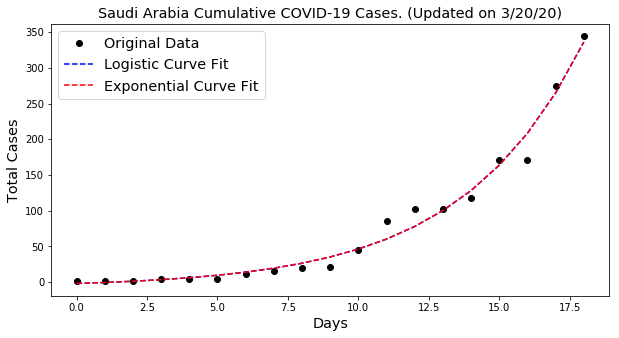



Slovenia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 341
	Confirmed cases on 3/13/20 	 141
	Ratio: 2.42
	Weekly increase: 141.8 %
	Daily increase: 13.4 % per day
	Doubling Time (represents recent growth): 5.5 days

** Based on Logistic Fit**

	R^2: 0.991935520153
	Doubling Time (during middle of growth):  2.55 (± 0.61 ) days


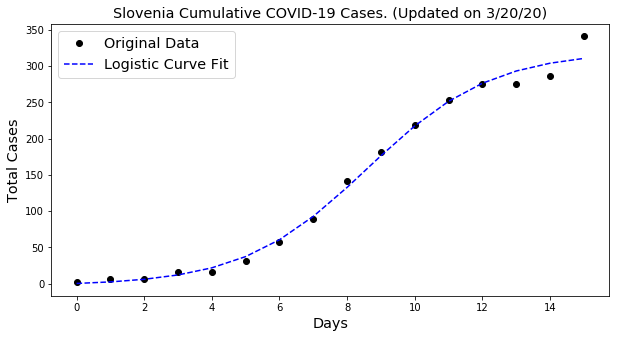



Thailand

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 322
	Confirmed cases on 3/13/20 	 75
	Ratio: 4.29
	Weekly increase: 329.3 %
	Daily increase: 23.1 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Exponential Fit **

	R^2: 0.969548971304
	Doubling Time (represents overall growth):  2.95 (± 0.28 ) days


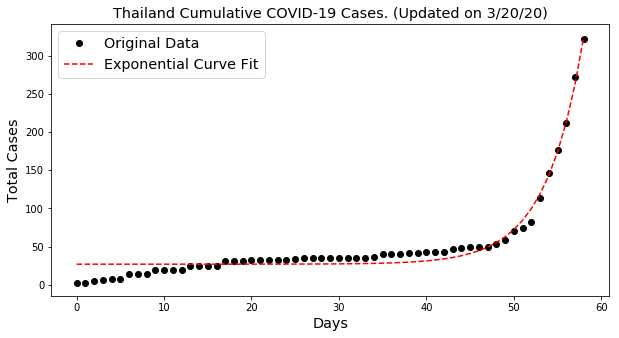



Romania

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 308
	Confirmed cases on 3/13/20 	 89
	Ratio: 3.46
	Weekly increase: 246.1 %
	Daily increase: 19.4 % per day
	Doubling Time (represents recent growth): 3.9 days

** Based on Logistic Fit**

	R^2: 0.99298335124
	Doubling Time (during middle of growth):  3.98 (± 0.8 ) days

** Based on Exponential Fit **

	R^2: 0.982644599658
	Doubling Time (represents overall growth):  3.81 (± 0.55 ) days


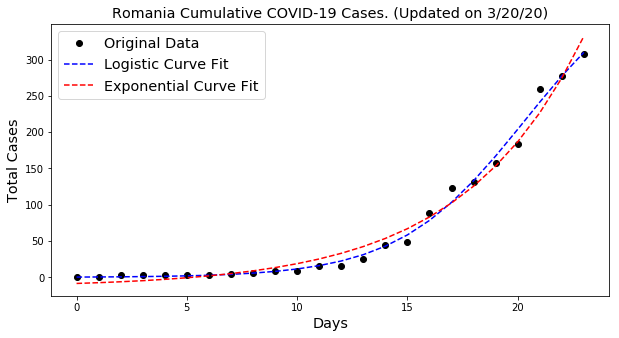



Bahrain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 285
	Confirmed cases on 3/13/20 	 189
	Ratio: 1.51
	Weekly increase: 50.8 %
	Daily increase: 6.0 % per day
	Doubling Time (represents recent growth): 11.8 days

** Based on Logistic Fit**

	R^2: 0.971170495809
	Doubling Time (during middle of growth):  4.92 (± 1.81 ) days

** Based on Exponential Fit **

	R^2: 0.956012708527
	Doubling Time (represents overall growth):  11.82 (± 5.57 ) days


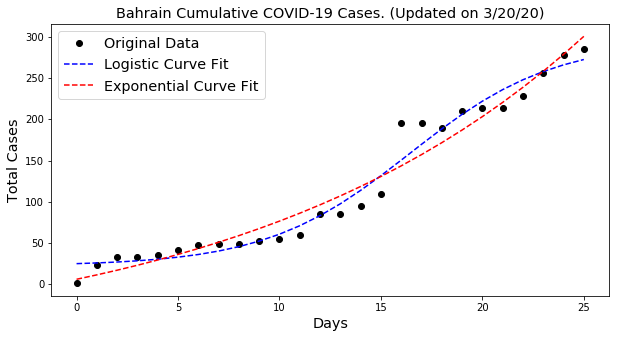



Egypt

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 285
	Confirmed cases on 3/13/20 	 80
	Ratio: 3.56
	Weekly increase: 256.2 %
	Daily increase: 19.9 % per day
	Doubling Time (represents recent growth): 3.8 days

** Based on Logistic Fit**

	R^2: 0.98938430402
	Doubling Time (during middle of growth):  6.47 (± 1.46 ) days

** Based on Exponential Fit **

	R^2: 0.988036974162
	Doubling Time (represents overall growth):  4.03 (± 0.34 ) days


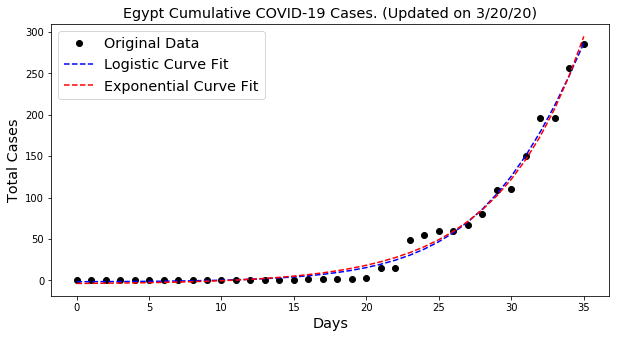



Estonia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 283
	Confirmed cases on 3/13/20 	 79
	Ratio: 3.58
	Weekly increase: 258.2 %
	Daily increase: 20.0 % per day
	Doubling Time (represents recent growth): 3.8 days

** Based on Logistic Fit**

	R^2: 0.995034793139
	Doubling Time (during middle of growth):  1.87 (± 0.28 ) days


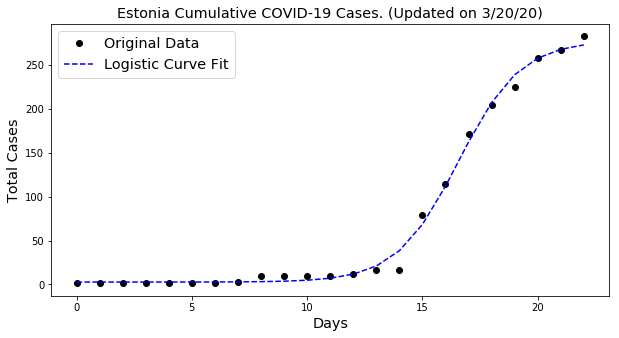



Russia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 253
	Confirmed cases on 3/13/20 	 45
	Ratio: 5.62
	Weekly increase: 462.2 %
	Daily increase: 28.0 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Exponential Fit **

	R^2: 0.998227862191
	Doubling Time (represents overall growth):  2.61 (± 0.06 ) days


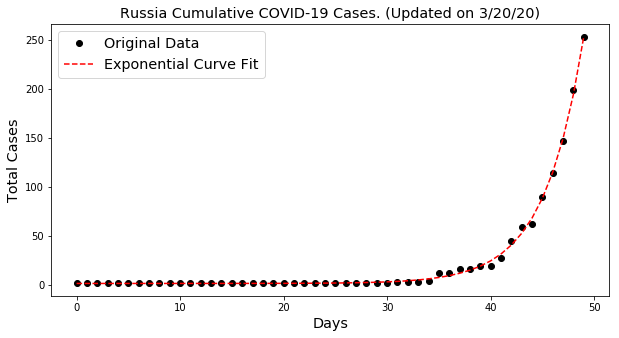



India

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 244
	Confirmed cases on 3/13/20 	 82
	Ratio: 2.98
	Weekly increase: 197.6 %
	Daily increase: 16.9 % per day
	Doubling Time (represents recent growth): 4.4 days

** Based on Exponential Fit **

	R^2: 0.991120235607
	Doubling Time (represents overall growth):  4.5 (± 0.26 ) days


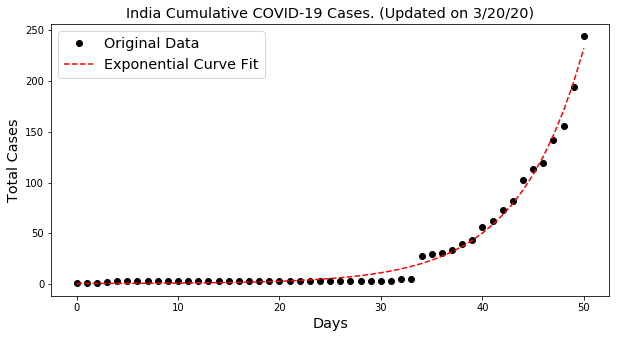



Peru

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 234
	Confirmed cases on 3/13/20 	 28
	Ratio: 8.36
	Weekly increase: 735.7 %
	Daily increase: 35.4 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.98503175973
	Doubling Time (during middle of growth):  2.35 (± 0.91 ) days

** Based on Exponential Fit **

	R^2: 0.971748001637
	Doubling Time (represents overall growth):  2.64 (± 0.69 ) days


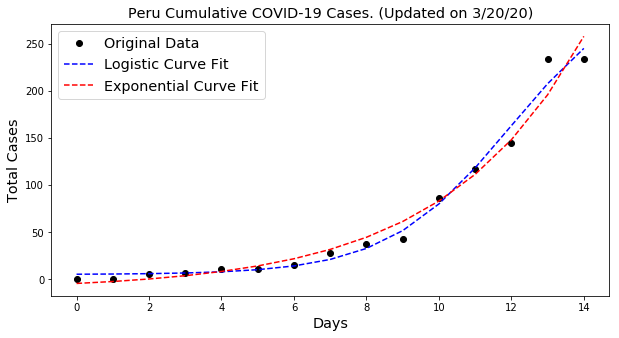



Philippines

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 230
	Confirmed cases on 3/13/20 	 64
	Ratio: 3.59
	Weekly increase: 259.4 %
	Daily increase: 20.1 % per day
	Doubling Time (represents recent growth): 3.8 days

** Based on Exponential Fit **

	R^2: 0.965572004483
	Doubling Time (represents overall growth):  3.93 (± 0.44 ) days


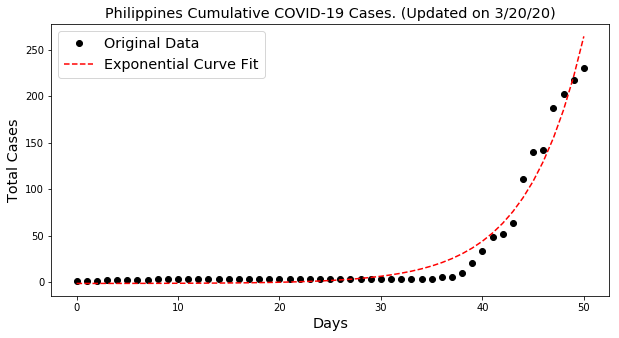



Iraq

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 208
	Confirmed cases on 3/13/20 	 101
	Ratio: 2.06
	Weekly increase: 105.9 %
	Daily increase: 10.9 % per day
	Doubling Time (represents recent growth): 6.7 days

** Based on Logistic Fit**

	R^2: 0.992079409884
	Doubling Time (during middle of growth):  14.28 (± 6.06 ) days

** Based on Exponential Fit **

	R^2: 0.992079410248
	Doubling Time (represents overall growth):  7.14 (± 0.92 ) days


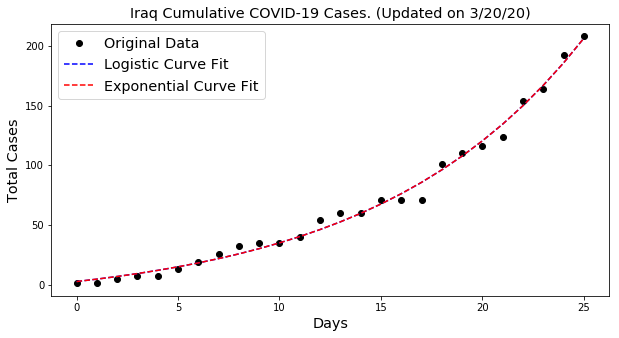



South Africa

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 202
	Confirmed cases on 3/13/20 	 24
	Ratio: 8.42
	Weekly increase: 741.7 %
	Daily increase: 35.6 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.990618340413
	Doubling Time (during middle of growth):  4.64 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.990618340753
	Doubling Time (represents overall growth):  2.32 (± 0.3 ) days


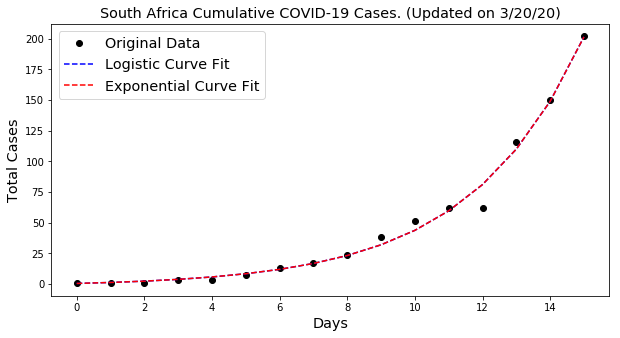



Mexico

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 164
	Confirmed cases on 3/13/20 	 12
	Ratio: 13.67
	Weekly increase: 1266.7 %
	Daily increase: 45.3 % per day
	Doubling Time (represents recent growth): 1.9 days

** Based on Logistic Fit**

	R^2: 0.992521893284
	Doubling Time (during middle of growth):  3.39 (± 0.81 ) days

** Based on Exponential Fit **

	R^2: 0.989964504736
	Doubling Time (represents overall growth):  2.33 (± 0.24 ) days


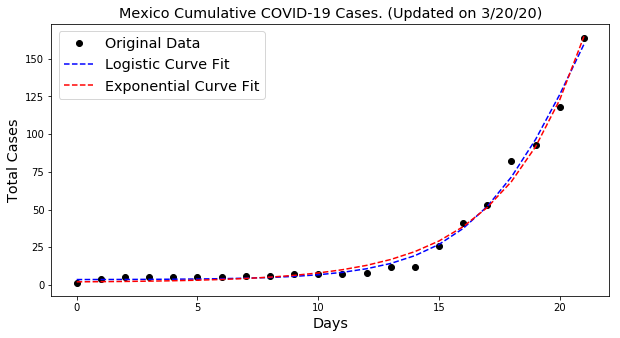



Lebanon

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 163
	Confirmed cases on 3/13/20 	 77
	Ratio: 2.12
	Weekly increase: 111.7 %
	Daily increase: 11.3 % per day
	Doubling Time (represents recent growth): 6.5 days

** Based on Logistic Fit**

	R^2: 0.991996273921
	Doubling Time (during middle of growth):  6.44 (± 1.4 ) days

** Based on Exponential Fit **

	R^2: 0.98624525515
	Doubling Time (represents overall growth):  6.13 (± 0.82 ) days


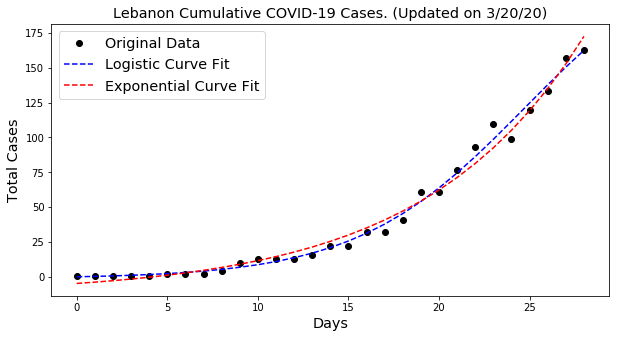



Kuwait

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 159
	Confirmed cases on 3/13/20 	 80
	Ratio: 1.99
	Weekly increase: 98.8 %
	Daily increase: 10.3 % per day
	Doubling Time (represents recent growth): 7.1 days


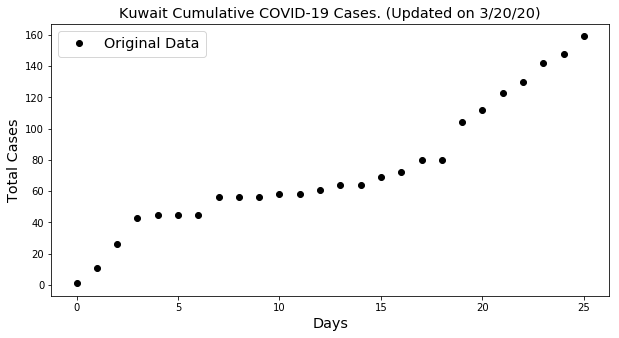



San Marino

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 144
	Confirmed cases on 3/13/20 	 80
	Ratio: 1.8
	Weekly increase: 80.0 %
	Daily increase: 8.8 % per day
	Doubling Time (represents recent growth): 8.3 days

** Based on Logistic Fit**

	R^2: 0.991254825679
	Doubling Time (during middle of growth):  6.39 (± 1.87 ) days

** Based on Exponential Fit **

	R^2: 0.984335614424
	Doubling Time (represents overall growth):  11.61 (± 3.8 ) days


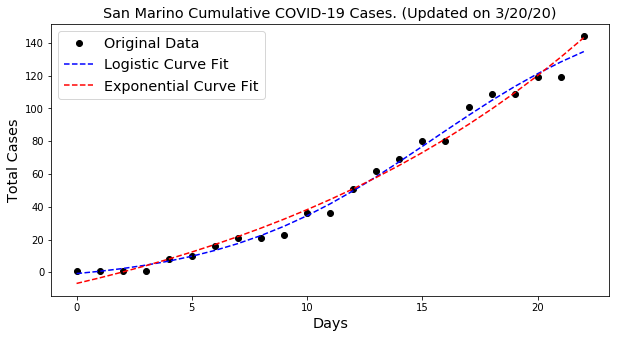



United Arab Emirates

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 140
	Confirmed cases on 3/13/20 	 85
	Ratio: 1.65
	Weekly increase: 64.7 %
	Daily increase: 7.4 % per day
	Doubling Time (represents recent growth): 9.7 days

** Based on Logistic Fit**

	R^2: 0.984054502043
	Doubling Time (during middle of growth):  8.51 (± 1.7 ) days

** Based on Exponential Fit **

	R^2: 0.978537565873
	Doubling Time (represents overall growth):  7.21 (± 0.71 ) days


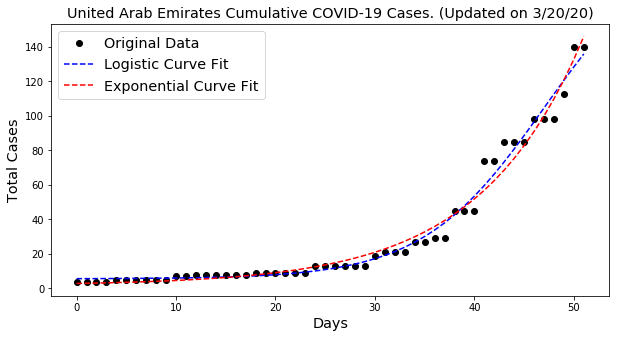



Panama

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 137
	Confirmed cases on 3/13/20 	 27
	Ratio: 5.07
	Weekly increase: 407.4 %
	Daily increase: 26.1 % per day
	Doubling Time (represents recent growth): 3.0 days

** Based on Logistic Fit**

	R^2: 0.996350910891
	Doubling Time (during middle of growth):  8.32 (± 2.25 ) days

** Based on Exponential Fit **

	R^2: 0.996350911244
	Doubling Time (represents overall growth):  4.16 (± 0.81 ) days


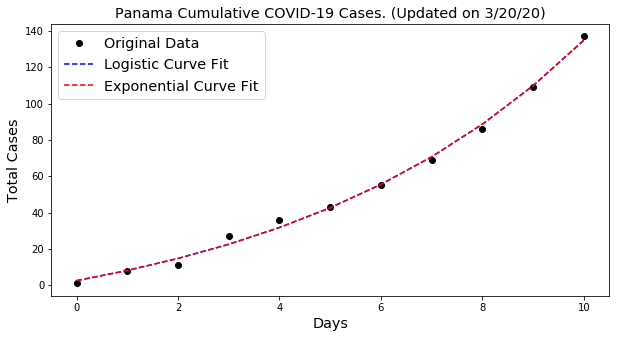



Slovakia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 137
	Confirmed cases on 3/13/20 	 32
	Ratio: 4.28
	Weekly increase: 328.1 %
	Daily increase: 23.1 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Logistic Fit**

	R^2: 0.99191438467
	Doubling Time (during middle of growth):  4.43 (± 1.87 ) days

** Based on Exponential Fit **

	R^2: 0.988516303413
	Doubling Time (represents overall growth):  4.14 (± 0.9 ) days


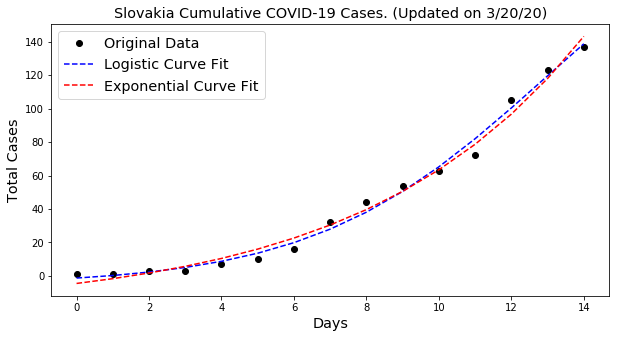



Armenia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 136
	Confirmed cases on 3/13/20 	 8
	Ratio: 17.0
	Weekly increase: 1600.0 %
	Daily increase: 49.9 % per day
	Doubling Time (represents recent growth): 1.7 days

** Based on Logistic Fit**

	R^2: 0.993243712395
	Doubling Time (during middle of growth):  2.32 (± 0.47 ) days

** Based on Exponential Fit **

	R^2: 0.975175488387
	Doubling Time (represents overall growth):  2.51 (± 0.44 ) days


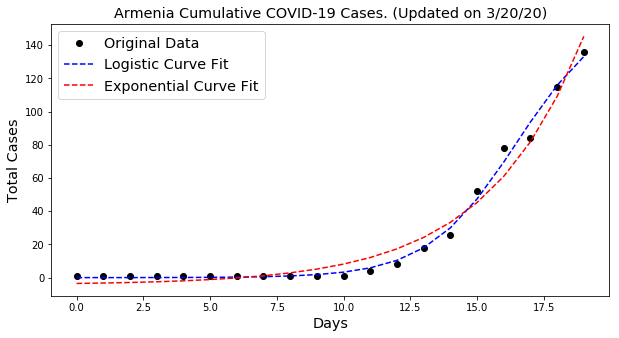



Taiwan*

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 135
	Confirmed cases on 3/13/20 	 50
	Ratio: 2.7
	Weekly increase: 170.0 %
	Daily increase: 15.2 % per day
	Doubling Time (represents recent growth): 4.9 days


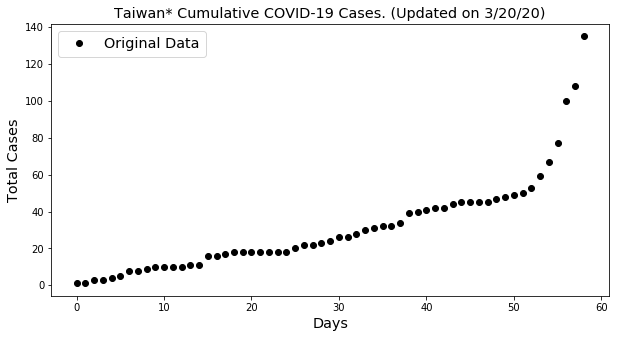



Serbia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 135
	Confirmed cases on 3/13/20 	 35
	Ratio: 3.86
	Weekly increase: 285.7 %
	Daily increase: 21.3 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Logistic Fit**

	R^2: 0.985954164967
	Doubling Time (during middle of growth):  7.9 (± 3.25 ) days

** Based on Exponential Fit **

	R^2: 0.985954165588
	Doubling Time (represents overall growth):  3.95 (± 0.92 ) days


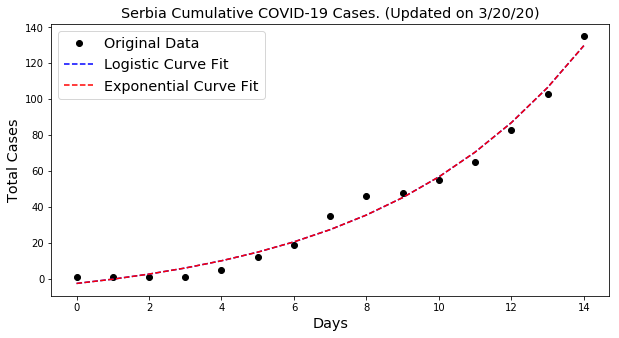



Croatia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 128
	Confirmed cases on 3/13/20 	 32
	Ratio: 4.0
	Weekly increase: 300.0 %
	Daily increase: 21.9 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Logistic Fit**

	R^2: 0.995011392436
	Doubling Time (during middle of growth):  6.14 (± 1.48 ) days

** Based on Exponential Fit **

	R^2: 0.995008458671
	Doubling Time (represents overall growth):  3.11 (± 0.21 ) days


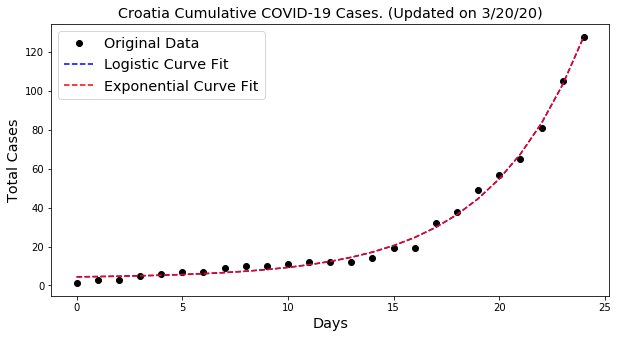



Argentina

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 128
	Confirmed cases on 3/13/20 	 31
	Ratio: 4.13
	Weekly increase: 312.9 %
	Daily increase: 22.5 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Logistic Fit**

	R^2: 0.995322904982
	Doubling Time (during middle of growth):  6.98 (± 4.52 ) days

** Based on Exponential Fit **

	R^2: 0.995322905672
	Doubling Time (represents overall growth):  3.49 (± 0.34 ) days


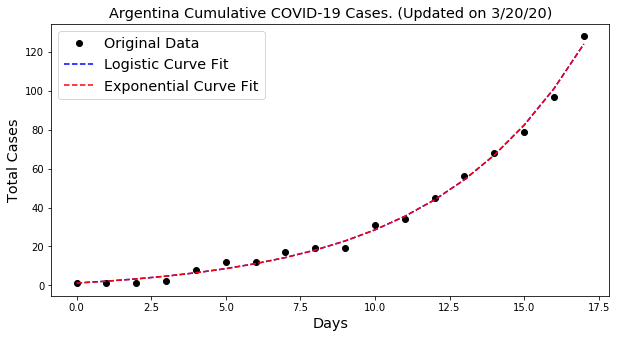



Colombia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 128
	Confirmed cases on 3/13/20 	 13
	Ratio: 9.85
	Weekly increase: 884.6 %
	Daily increase: 38.6 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.99562176075
	Doubling Time (during middle of growth):  2.9 (± 0.65 ) days

** Based on Exponential Fit **

	R^2: 0.986353662781
	Doubling Time (represents overall growth):  3.12 (± 0.62 ) days


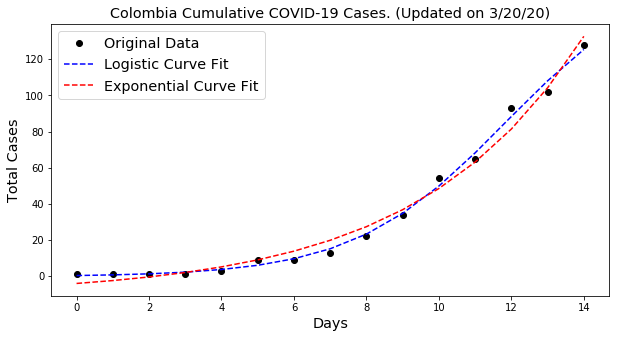



Bulgaria

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 127
	Confirmed cases on 3/13/20 	 23
	Ratio: 5.52
	Weekly increase: 452.2 %
	Daily increase: 27.6 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Logistic Fit**

	R^2: 0.978401799862
	Doubling Time (during middle of growth):  5.36 (± 6.28 ) days

** Based on Exponential Fit **

	R^2: 0.977484147139
	Doubling Time (represents overall growth):  4.42 (± 1.76 ) days


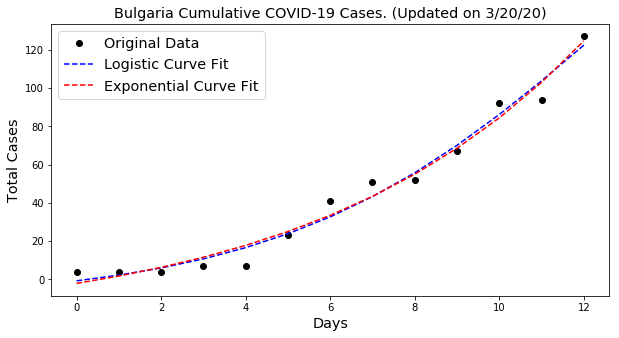



Latvia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 111
	Confirmed cases on 3/13/20 	 17
	Ratio: 6.53
	Weekly increase: 552.9 %
	Daily increase: 30.7 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Logistic Fit**

	R^2: 0.995945976938
	Doubling Time (during middle of growth):  4.74 (± 1.2 ) days

** Based on Exponential Fit **

	R^2: 0.995742402814
	Doubling Time (represents overall growth):  2.66 (± 0.21 ) days


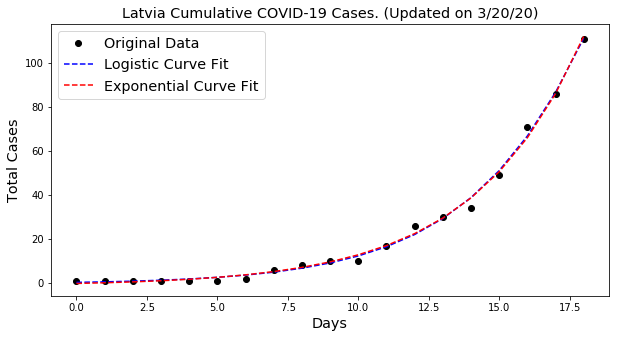

In [5]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

for c in topcountries:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for Global COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


               Countries  Inferred Doubling Time  Recent Doubling Time
0                  China                     6.5                1290.1
1                  Italy                     4.5                   5.0
2                  Spain                     3.2                   3.6
3                Germany                     2.8                   2.9
4                   Iran                     7.4                   8.9
5                     US                     2.0                   2.2
6                 France                     3.6                   3.9
7           Korea, South                     4.3                  59.9
8            Switzerland                     3.2                   3.2
9         United Kingdom                     3.0                   3.0
10         

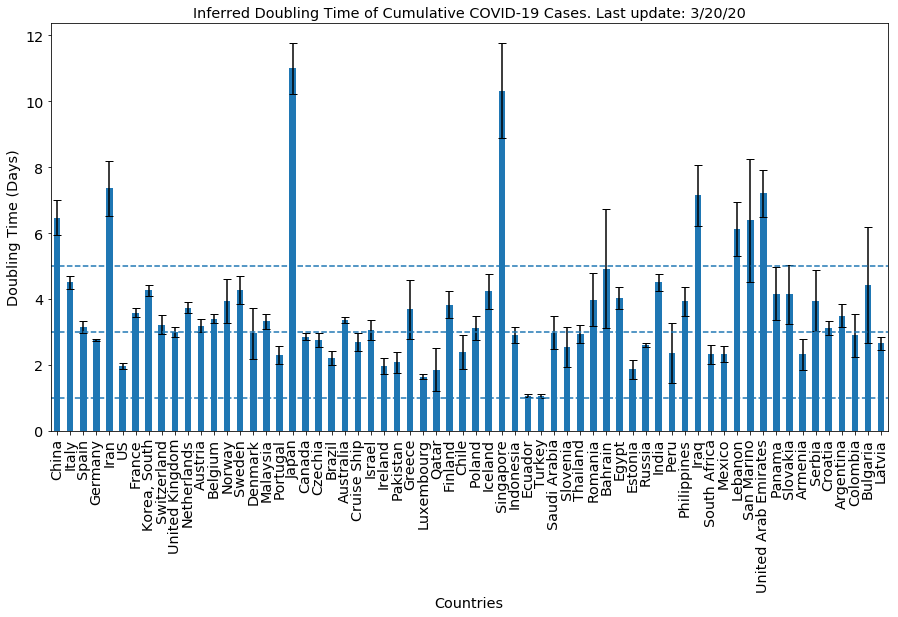

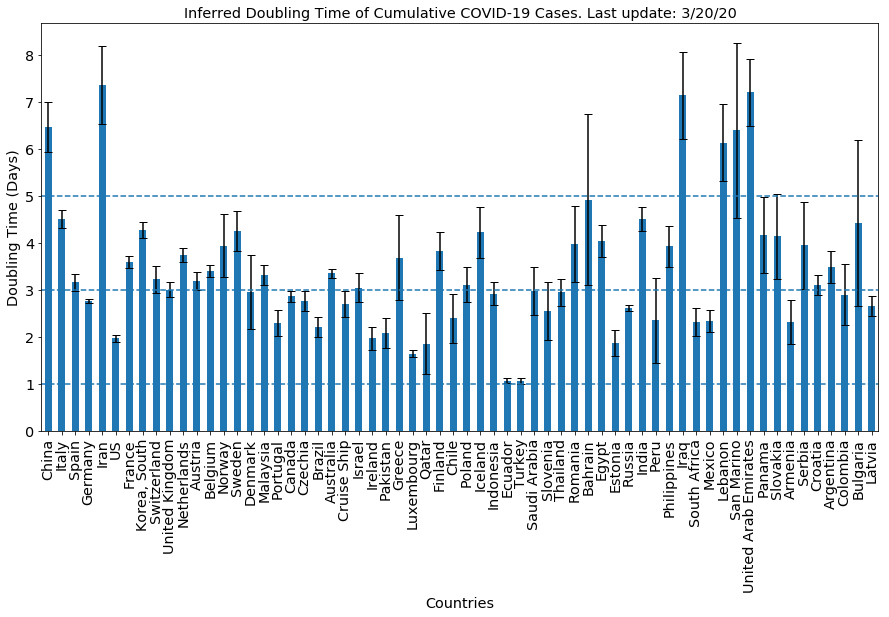

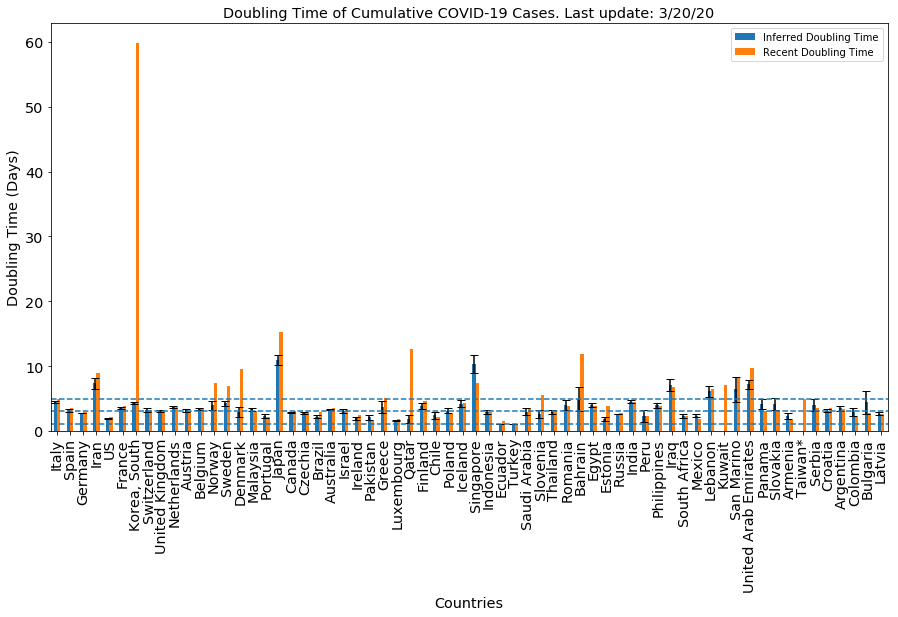

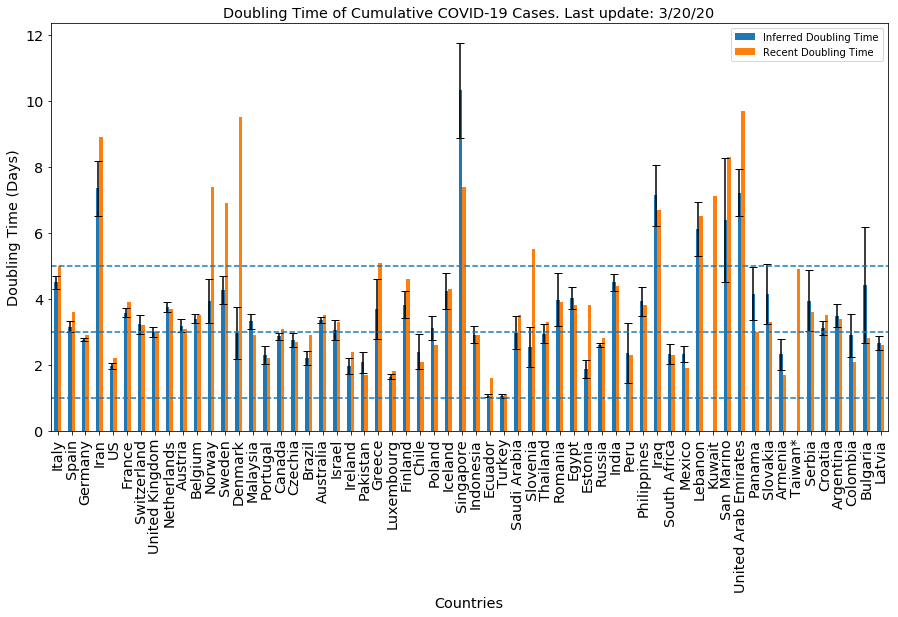

In [6]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 10]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=countries
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 10]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

## US COVID-19 Analysis

In [7]:
uscases = df[df['Country/Region'] == 'US'].copy()

# US states lookup from https://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/
# with DC added
states = { 'AK': 'Alaska', 'AL': 'Alabama', 'AR': 'Arkansas', 'AS': 'American Samoa', 'AZ': 'Arizona', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DC': 'District of Columbia', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'GU': 'Guam', 'HI': 'Hawaii', 'IA': 'Iowa', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'MA': 'Massachusetts', 'MD': 'Maryland', 'ME': 'Maine', 'MI': 'Michigan', 'MN': 'Minnesota', 'MO': 'Missouri', 'MP': 'Northern Mariana Islands', 'MS': 'Mississippi', 'MT': 'Montana', 'NA': 'National', 'NC': 'North Carolina', 'ND': 'North Dakota', 'NE': 'Nebraska', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NV': 'Nevada', 'NY': 'New York', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'PR': 'Puerto Rico', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VA': 'Virginia', 'VI': 'Virgin Islands', 'VT': 'Vermont', 'WA': 'Washington', 'WI': 'Wisconsin', 'WV': 'West Virginia', 'WY': 'Wyoming', 'D.C.': 'District of Columbia'}

for index, row in uscases.iterrows():
    location = row['Province/State']
    try:
        if ',' in location:
            result = [x.strip() for x in location.split(',')]
            statename = states[result[1]]
            row['State'] = statename
            uscases.loc[index, 'Province/State'] = statename
    except:
        print('Error parsing US state:', location)        
            
usstatesummary = uscases.iloc[:,[0,-1]].groupby('Province/State').sum()
mostrecentdate = usstatesummary.columns[0]
usstatesummary = usstatesummary.sort_values(by = mostrecentdate, ascending = False)
usstatesummary = usstatesummary[usstatesummary[mostrecentdate] > 0]

print('\nNumber of confirmed US COVID-19 cases by state as of', mostrecentdate)
usstatesummary


Number of confirmed US COVID-19 cases by state as of 3/20/20


,3/20/20
Province/State,
New York,8310
Washington,1524
California,1177
New Jersey,890
Illinois,585
Florida,563
Michigan,552
Louisiana,538
Georgia,420


## Curve Fitting US COVID-19 Cases

                3/20/20
Province/State         
New York           8310
Washington         1524
California         1177
New Jersey          890
Illinois            585
Florida             563
Michigan            552
Louisiana           538
Georgia             420
Massachusetts       413
Texas               394
Colorado            363
Pennsylvania        303
Tennessee           233
Wisconsin           207
Connecticut         194
Ohio                173
North Carolina      172
Maryland            149
South Carolina      126
Virginia            122
Minnesota           115
Nevada              114
Oregon              114


US state:  New York

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 8310
	Confirmed cases on 3/13/20 	 421
	Ratio: 19.74
	Weekly increase: 1873.9 %
	Daily increase: 53.1 % per day
	Doubling Time (represents recent growth): 1.6 days

** Based on Exponential Fit **

	R^2: 0.994434457599
	Doubling Time (represents overall growth):  1.28 (± 0.1 ) days


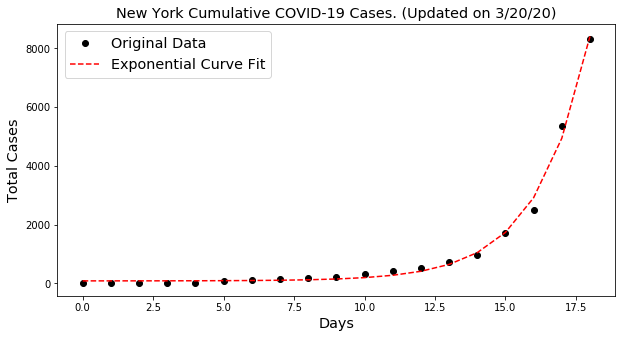



US state:  Washington

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 1524
	Confirmed cases on 3/13/20 	 568
	Ratio: 2.68
	Weekly increase: 168.3 %
	Daily increase: 15.1 % per day
	Doubling Time (represents recent growth): 4.9 days

** Based on Exponential Fit **

	R^2: 0.986077834661
	Doubling Time (represents overall growth):  4.02 (± 0.26 ) days


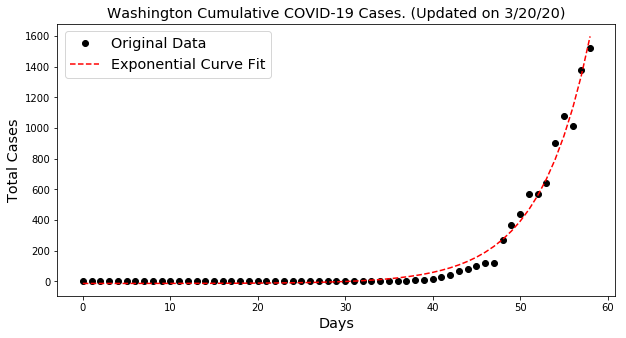



US state:  California

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 1177
	Confirmed cases on 3/13/20 	 282
	Ratio: 4.17
	Weekly increase: 317.4 %
	Daily increase: 22.6 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Exponential Fit **

	R^2: 0.997600066159
	Doubling Time (represents overall growth):  3.36 (± 0.09 ) days


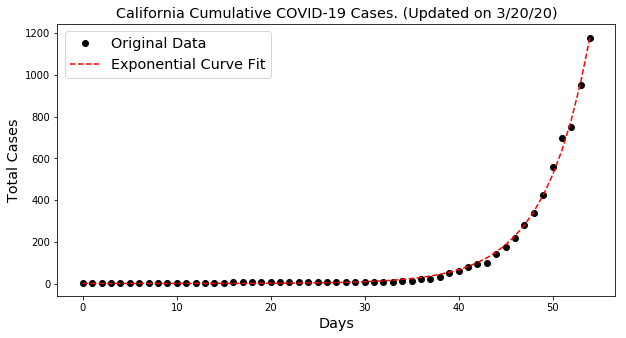



US state:  New Jersey

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 890
	Confirmed cases on 3/13/20 	 29
	Ratio: 30.69
	Weekly increase: 2969.0 %
	Daily increase: 63.1 % per day
	Doubling Time (represents recent growth): 1.4 days

** Based on Logistic Fit**

	R^2: 0.96922011939
	Doubling Time (during middle of growth):  2.21 (± 1.36 ) days

** Based on Exponential Fit **

	R^2: 0.966484610882
	Doubling Time (represents overall growth):  1.6 (± 0.36 ) days


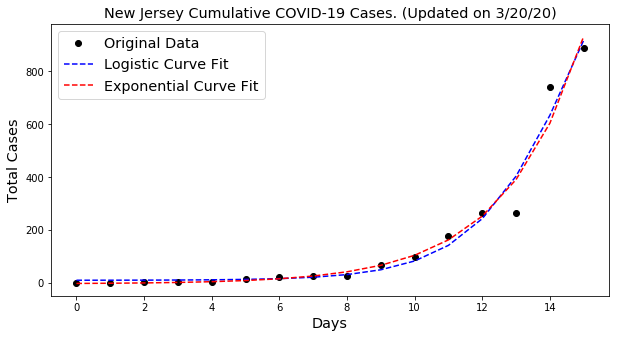



US state:  Illinois

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 585
	Confirmed cases on 3/13/20 	 46
	Ratio: 12.72
	Weekly increase: 1171.7 %
	Daily increase: 43.8 % per day
	Doubling Time (represents recent growth): 1.9 days

** Based on Exponential Fit **

	R^2: 0.980917031741
	Doubling Time (represents overall growth):  1.56 (± 0.12 ) days


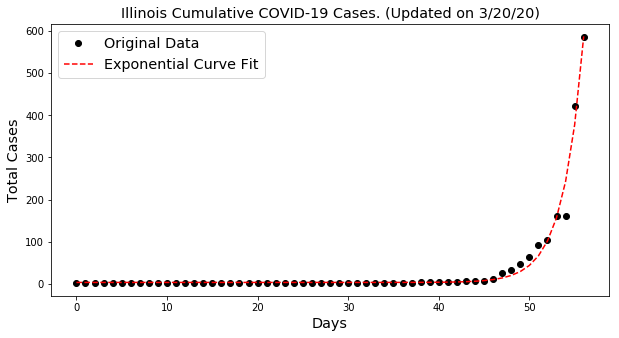



US state:  Florida

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 563
	Confirmed cases on 3/13/20 	 50
	Ratio: 11.26
	Weekly increase: 1026.0 %
	Daily increase: 41.3 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Logistic Fit**

	R^2: 0.999700441504
	Doubling Time (during middle of growth):  3.64 (± 0.22 ) days

** Based on Exponential Fit **

	R^2: 0.999025230938
	Doubling Time (represents overall growth):  2.18 (± 0.08 ) days


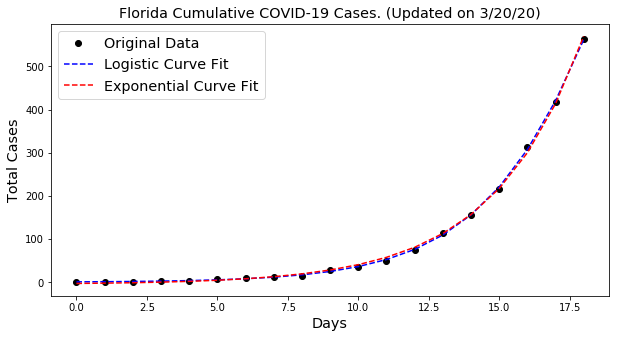



US state:  Michigan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 552
	Confirmed cases on 3/13/20 	 16
	Ratio: 34.5
	Weekly increase: 3350.0 %
	Daily increase: 65.8 % per day
	Doubling Time (represents recent growth): 1.4 days

** Based on Exponential Fit **

	R^2: 0.976496582976
	Doubling Time (represents overall growth):  0.98 (± 0.27 ) days


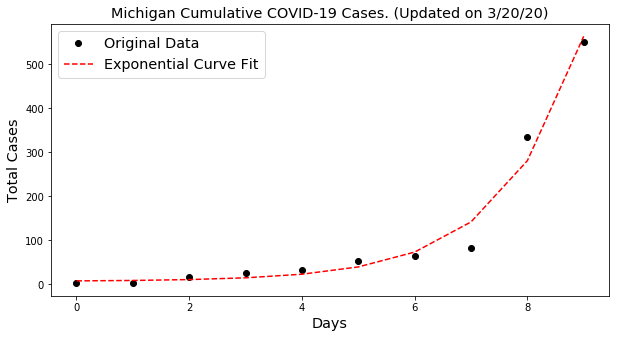



US state:  Louisiana

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 538
	Confirmed cases on 3/13/20 	 36
	Ratio: 14.94
	Weekly increase: 1394.4 %
	Daily increase: 47.2 % per day
	Doubling Time (represents recent growth): 1.8 days

** Based on Logistic Fit**

	R^2: 0.997989482118
	Doubling Time (during middle of growth):  4.29 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.997989482238
	Doubling Time (represents overall growth):  2.14 (± 0.17 ) days


/Users/aatish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


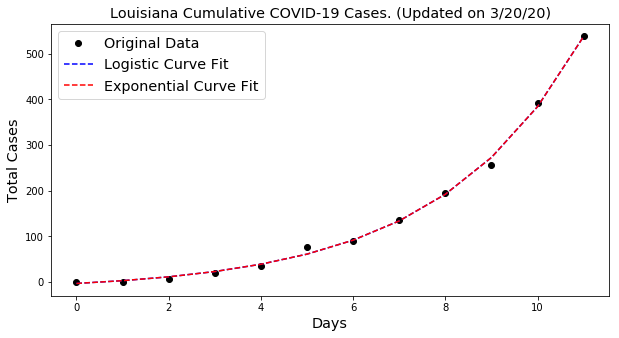



US state:  Georgia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 420
	Confirmed cases on 3/13/20 	 42
	Ratio: 10.0
	Weekly increase: 900.0 %
	Daily increase: 38.9 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.995753427554
	Doubling Time (during middle of growth):  4.25 (± 0.35 ) days

** Based on Exponential Fit **

	R^2: 0.995753427906
	Doubling Time (represents overall growth):  2.13 (± 0.16 ) days


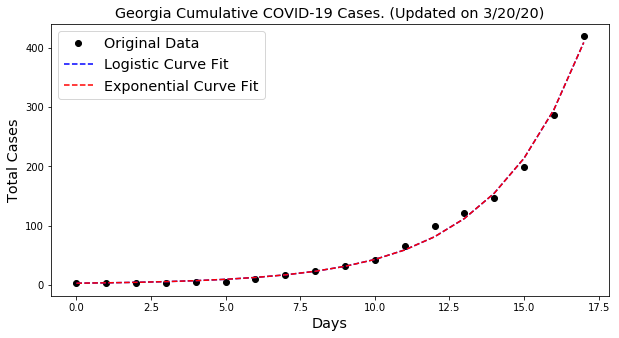



US state:  Massachusetts

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 413
	Confirmed cases on 3/13/20 	 123
	Ratio: 3.36
	Weekly increase: 235.8 %
	Daily increase: 18.9 % per day
	Doubling Time (represents recent growth): 4.0 days

** Based on Exponential Fit **

	R^2: 0.977122453643
	Doubling Time (represents overall growth):  3.68 (± 0.34 ) days


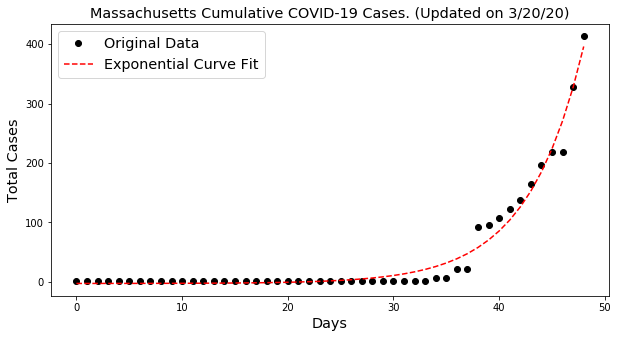



US state:  Texas

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 394
	Confirmed cases on 3/13/20 	 43
	Ratio: 9.16
	Weekly increase: 816.3 %
	Daily increase: 37.2 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.995444333575
	Doubling Time (during middle of growth):  3.44 (± 0.38 ) days

** Based on Exponential Fit **

	R^2: 0.995444333976
	Doubling Time (represents overall growth):  1.72 (± 0.14 ) days


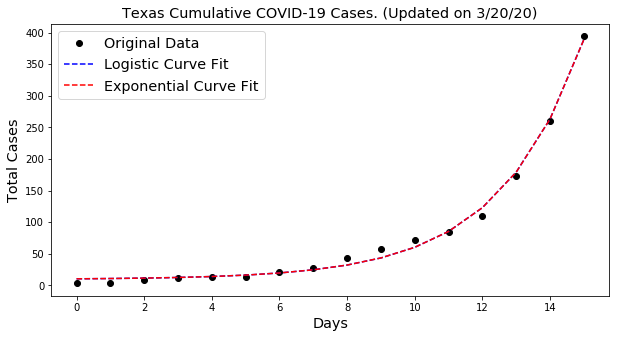



US state:  Colorado

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 363
	Confirmed cases on 3/13/20 	 49
	Ratio: 7.41
	Weekly increase: 640.8 %
	Daily increase: 33.1 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Logistic Fit**

	R^2: 0.978711530409
	Doubling Time (during middle of growth):  6.46 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.978711530819
	Doubling Time (represents overall growth):  3.23 (± 0.81 ) days


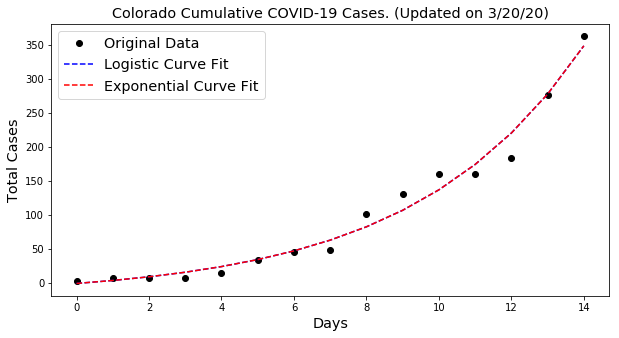



US state:  Pennsylvania

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 303
	Confirmed cases on 3/13/20 	 41
	Ratio: 7.39
	Weekly increase: 639.0 %
	Daily increase: 33.1 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Logistic Fit**

	R^2: 0.997015500678
	Doubling Time (during middle of growth):  4.25 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.997015501088
	Doubling Time (represents overall growth):  2.13 (± 0.16 ) days


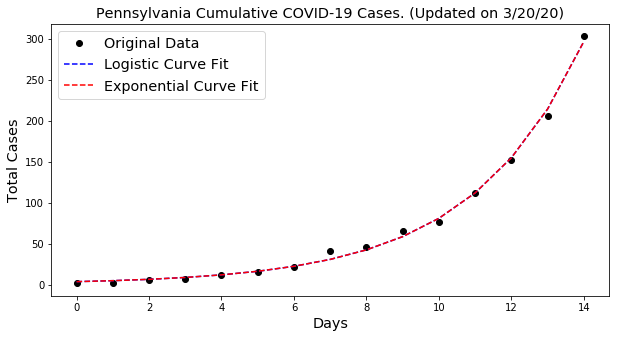



US state:  Tennessee

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 233
	Confirmed cases on 3/13/20 	 26
	Ratio: 8.96
	Weekly increase: 796.2 %
	Daily increase: 36.8 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.985271746612
	Doubling Time (during middle of growth):  3.35 (± 0.56 ) days

** Based on Exponential Fit **

	R^2: 0.985271746969
	Doubling Time (represents overall growth):  1.68 (± 0.25 ) days


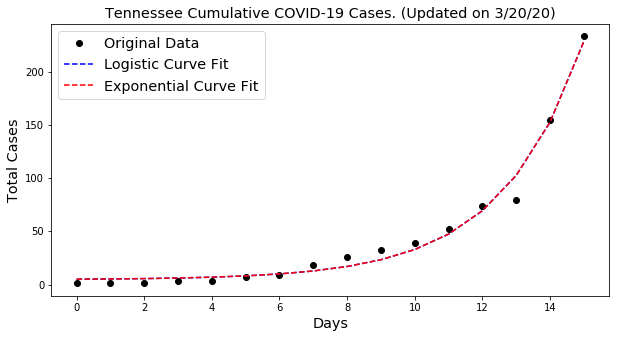



US state:  Wisconsin

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 207
	Confirmed cases on 3/13/20 	 19
	Ratio: 10.89
	Weekly increase: 989.5 %
	Daily increase: 40.7 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Logistic Fit**

	R^2: 0.993441320624
	Doubling Time (during middle of growth):  3.28 (± 1.85 ) days

** Based on Exponential Fit **

	R^2: 0.993188917062
	Doubling Time (represents overall growth):  1.94 (± 0.31 ) days


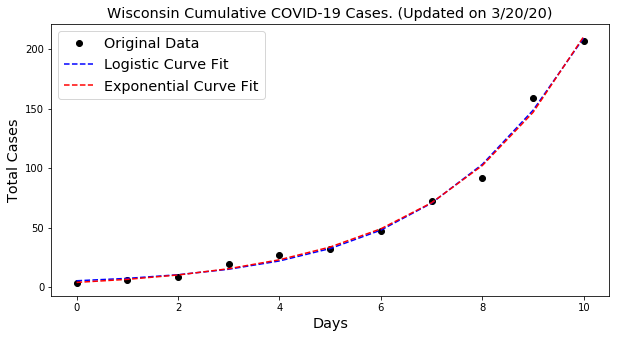



US state:  Connecticut

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 194
	Confirmed cases on 3/13/20 	 11
	Ratio: 17.64
	Weekly increase: 1663.6 %
	Daily increase: 50.7 % per day
	Doubling Time (represents recent growth): 1.7 days

** Based on Logistic Fit**

	R^2: 0.972674247808
	Doubling Time (during middle of growth):  2.14 (± 1.72 ) days

** Based on Exponential Fit **

	R^2: 0.969507042297
	Doubling Time (represents overall growth):  1.74 (± 0.56 ) days


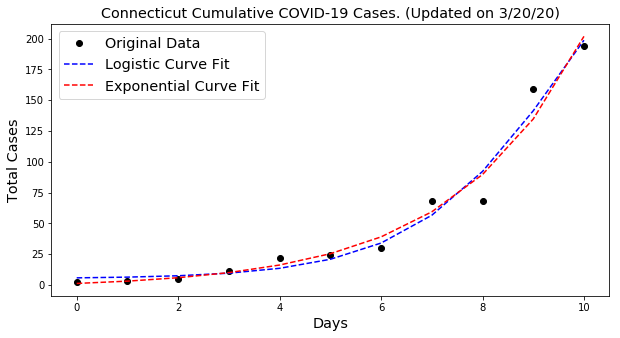



US state:  Ohio

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 173
	Confirmed cases on 3/13/20 	 13
	Ratio: 13.31
	Weekly increase: 1230.8 %
	Daily increase: 44.7 % per day
	Doubling Time (represents recent growth): 1.9 days

** Based on Logistic Fit**

	R^2: 0.995838364597
	Doubling Time (during middle of growth):  4.68 (± 1.02 ) days

** Based on Exponential Fit **

	R^2: 0.995838365264
	Doubling Time (represents overall growth):  2.34 (± 0.32 ) days


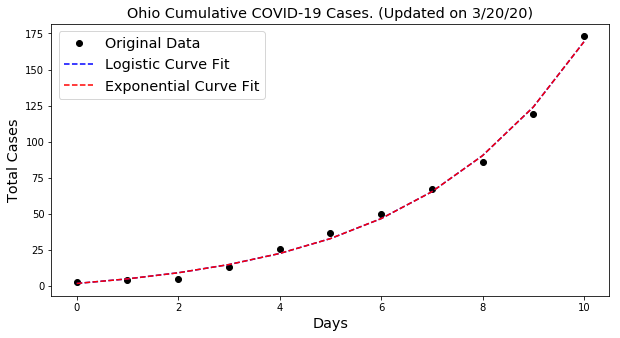



US state:  North Carolina

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 172
	Confirmed cases on 3/13/20 	 17
	Ratio: 10.12
	Weekly increase: 911.8 %
	Daily increase: 39.2 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.992228243733
	Doubling Time (during middle of growth):  3.82 (± 0.23 ) days

** Based on Exponential Fit **

	R^2: 0.992228243859
	Doubling Time (represents overall growth):  1.91 (± 0.19 ) days


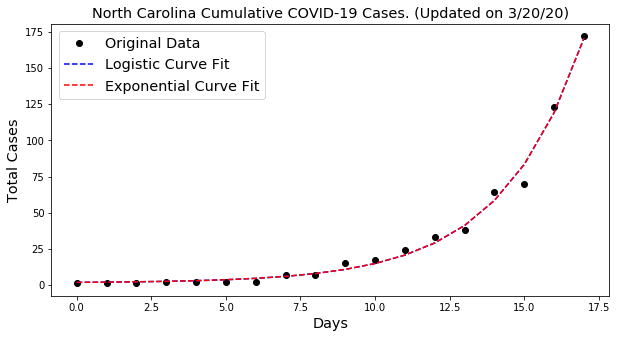



US state:  Maryland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 149
	Confirmed cases on 3/13/20 	 18
	Ratio: 8.28
	Weekly increase: 727.8 %
	Daily increase: 35.2 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.998510141277
	Doubling Time (during middle of growth):  4.32 (± 0.9 ) days

** Based on Exponential Fit **

	R^2: 0.998482220834
	Doubling Time (represents overall growth):  2.27 (± 0.13 ) days


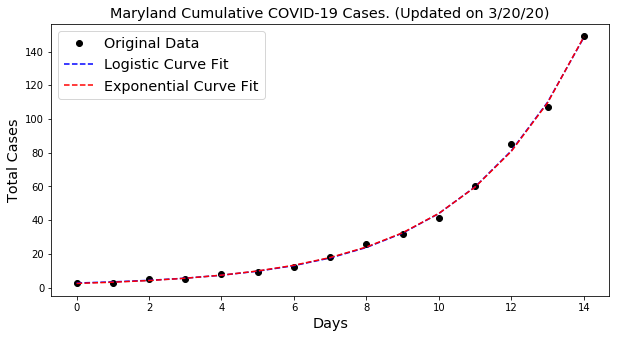



US state:  South Carolina

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 126
	Confirmed cases on 3/13/20 	 13
	Ratio: 9.69
	Weekly increase: 869.2 %
	Daily increase: 38.3 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.981619027838
	Doubling Time (during middle of growth):  3.66 (± 1.31 ) days

** Based on Exponential Fit **

	R^2: 0.981619029718
	Doubling Time (represents overall growth):  1.83 (± 0.36 ) days


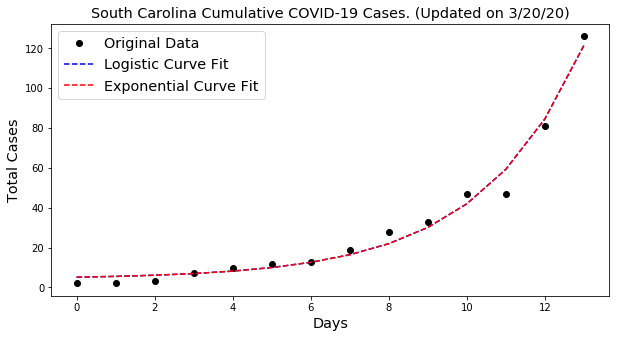



US state:  Virginia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 122
	Confirmed cases on 3/13/20 	 30
	Ratio: 4.07
	Weekly increase: 306.7 %
	Daily increase: 22.2 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Logistic Fit**

	R^2: 0.991260802018
	Doubling Time (during middle of growth):  8.83 (± 4.71 ) days

** Based on Exponential Fit **

	R^2: 0.991260802359
	Doubling Time (represents overall growth):  4.42 (± 1.09 ) days


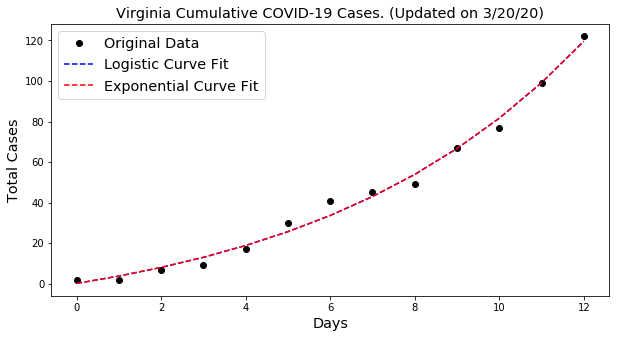



US state:  Minnesota

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 115
	Confirmed cases on 3/13/20 	 14
	Ratio: 8.21
	Weekly increase: 721.4 %
	Daily increase: 35.1 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.993118574842
	Doubling Time (during middle of growth):  3.46 (± 1.09 ) days

** Based on Exponential Fit **

	R^2: 0.987584369609
	Doubling Time (represents overall growth):  3.33 (± 0.65 ) days


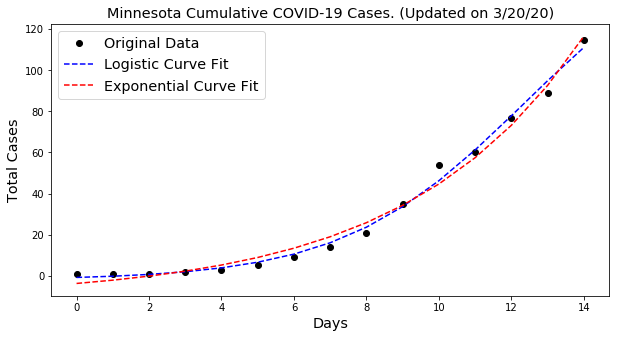



US state:  Nevada

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 114
	Confirmed cases on 3/13/20 	 17
	Ratio: 6.71
	Weekly increase: 570.6 %
	Daily increase: 31.2 % per day
	Doubling Time (represents recent growth): 2.5 days

** Based on Logistic Fit**

	R^2: 0.98338293267
	Doubling Time (during middle of growth):  4.88 (± 3.39 ) days

** Based on Exponential Fit **

	R^2: 0.983343073797
	Doubling Time (represents overall growth):  2.59 (± 0.47 ) days


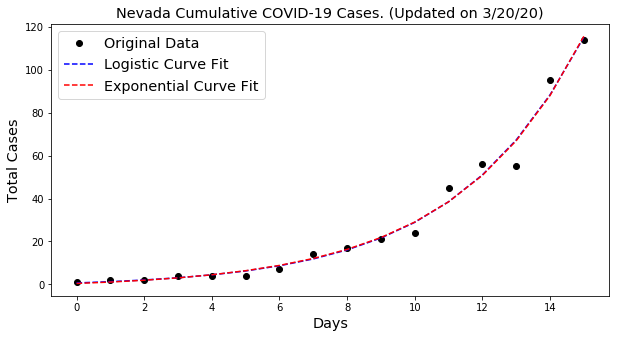



US state:  Oregon

** Based on Most Recent Week of Data **

	Confirmed cases on 3/20/20 	 114
	Confirmed cases on 3/13/20 	 30
	Ratio: 3.8
	Weekly increase: 280.0 %
	Daily increase: 21.0 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Logistic Fit**

	R^2: 0.987022585543
	Doubling Time (during middle of growth):  6.62 (± 1.71 ) days

** Based on Exponential Fit **

	R^2: 0.98702258643
	Doubling Time (represents overall growth):  3.31 (± 0.44 ) days


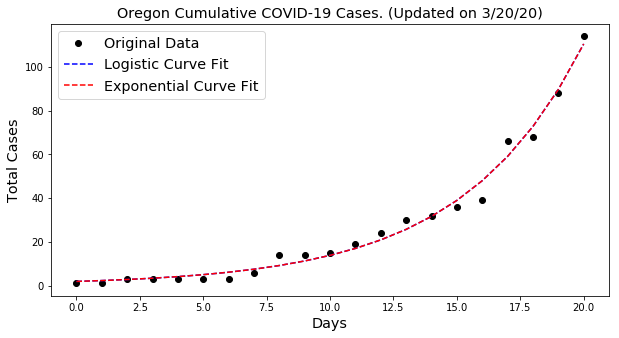

In [8]:
topusstates = usstatesummary[usstatesummary[mostrecentdate] >= 100]
print(topusstates)

print('\n');
inferreddoublingtime = []
recentdoublingtime = []
errors = []
states = []

for state in topusstates.index.values:
    print('US state: ', state)
    a = plotCases(uscases,'Province/State', state)
    if a:
        states.append(state)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for US COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


            States  Inferred Doubling Time  Recent Doubling Time
0         New York                     1.3                   1.6
1       Washington                     4.0                   4.9
2       California                     3.4                   3.4
3       New Jersey                     1.6                   1.4
4         Illinois                     1.6                   1.9
5          Florida                     2.2                   2.0
6         Michigan                     1.0                   1.4
7        Louisiana                     2.1                   1.8
8          Georgia                     2.1                   2.1
9    Massachusetts                     3.7                   4.0
10           Texas                     1.7                   2.2
11        Co

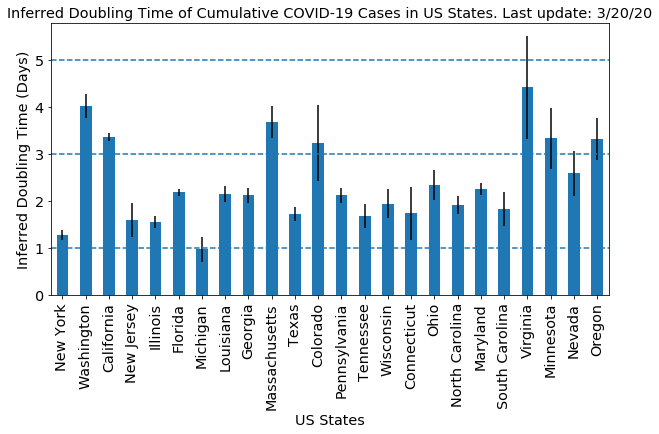

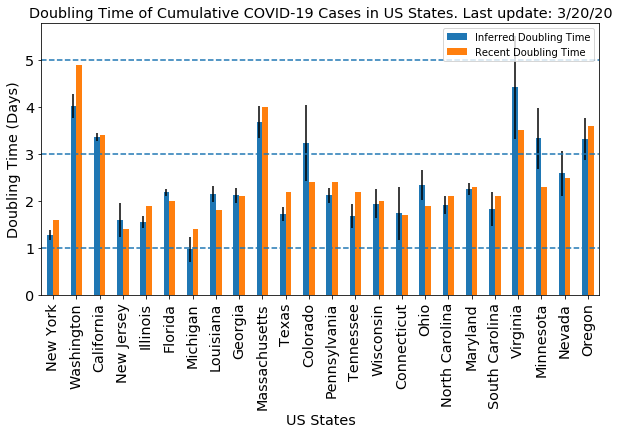

In [9]:
d = {'States': states, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')
print(pd.DataFrame(data=d).iloc[:,[3,1,2]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'States', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Inferred Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=states
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=states)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(yerr=err, figsize=(10,5), fontsize="x-large")
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()